In [1]:
import numpy as np
import pandas as pd 
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

color = sns.color_palette()
sns.set_style('darkgrid')
import warnings
warnings.filterwarnings('ignore') #ignore annoying warning (from sklearn and seaborn)

from scipy import stats
from scipy.stats import norm, skew
%config InlineBackend.figure_format ='retina'

# Kaggle House Prices Competition Kernel

In this competition we are given a training dataset of houses in Boston and asked to build a model to predict house prices for our test dataset.

Our training dataset has 1460 houses and 81 variables--80 are features of the house and one variable is our target, SalePrice.

We will clean our data and build a model on the training dataset that explains the relationship between the features of the house and our SalePrice. After selecting and tuning our model, we will create SalePrice predictions for the test dataset houses.

## Read-in and examine train and test datasets

In [2]:
#Now let's import and put the train and test datasets in  pandas dataframe
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

# Take a look at some descriptive stats
train.describe()

Id   MSSubClass  LotFrontage        LotArea  OverallQual  \
count  1460.000000  1460.000000  1201.000000    1460.000000  1460.000000   
mean    730.500000    56.897260    70.049958   10516.828082     6.099315   
std     421.610009    42.300571    24.284752    9981.264932     1.382997   
min       1.000000    20.000000    21.000000    1300.000000     1.000000   
25%     365.750000    20.000000    59.000000    7553.500000     5.000000   
50%     730.500000    50.000000    69.000000    9478.500000     6.000000   
75%    1095.250000    70.000000    80.000000   11601.500000     7.000000   
max    1460.000000   190.000000   313.000000  215245.000000    10.000000   

       OverallCond    YearBuilt  YearRemodAdd   MasVnrArea   BsmtFinSF1  ...  \
count  1460.000000  1460.000000   1460.000000  1452.000000  1460.000000  ...   
mean      5.575342  1971.267808   1984.865753   103.685262   443.639726  ...   
std       1.112799    30.202904     20.645407   181.066207   456.098091  ...   
min       1.000000  1872.000000   1950.000000     0.000000     0.000000  ...   
25%       5.000000  1954.000000   1967.000000     0.000000     0.000000  ...   
50%       5.000000  1973.000000   1994.000000     0.000000   383.500000  ...   
75%       6.000000  2000.000000   2004.000000   166.000000   712.250000  ...   
max       9.000000  2010.000000   2010.000000  1600.000000  5644.000000  ...   

        WoodDeckSF  OpenPorchSF  EnclosedPorch    3SsnPorch  ScreenPorch  \
count  1460.000000  1460.000000    1460.000000  1460.000000  1460.000000   
mean     94.244521    46.660274      21.954110     3.409589    15.060959   
std     125.338794    66.256028      61.119149    29.317331    55.757415   
min       0.000000     0.000000       0.000000     0.000000     0.000000   
25%       0.000000     0.000000       0.000000     0.000000     0.000000   
50%       0.000000    25.000000       0.000000     0.000000     0.000000   
75%     168.000000    68.000000       0.000000     0.000000     0.000000   
max     857.000000   547.000000     552.000000   508.000000   480.000000   

          PoolArea       MiscVal       MoSold       YrSold      SalePrice  
count  1460.000000   1460.000000  1460.000000  1460.000000    1460.000000  
mean      2.758904     43.489041     6.321918  2007.815753  180921.195890  
std      40.177307    496.123024     2.703626     1.328095   79442.502883  
min       0.000000      0.000000     1.000000  2006.000000   34900.000000  
25%       0.000000      0.000000     5.000000  2007.000000  129975.000000  
50%       0.000000      0.000000     6.000000  2008.000000  163000.000000  
75%       0.000000      0.000000     8.000000  2009.000000  214000.000000  
max     738.000000  15500.000000    12.000000  2010.000000  755000.000000  

[8 rows x 38 columns]

In [3]:
print ("Size of train data : {}" .format(train.shape))
print ("Size of test data : {}" .format(test.shape))

Size of train data : (1460, 81)
Size of test data : (1459, 80)


In [4]:
#Save the 'Id' column
train_ID = train['Id']
test_ID = test['Id']

#Now drop the 'ID' colum since it's unnecessary for the prediction process.
train.drop("Id", axis = 1, inplace = True)
test.drop("Id", axis = 1, inplace = True)

```python
```
## Exploratory data analysis and light cleaning 

We can begin by looking at the distribution of our target--SalePrice


 mean = 180921.20 and stddev = 79415.29



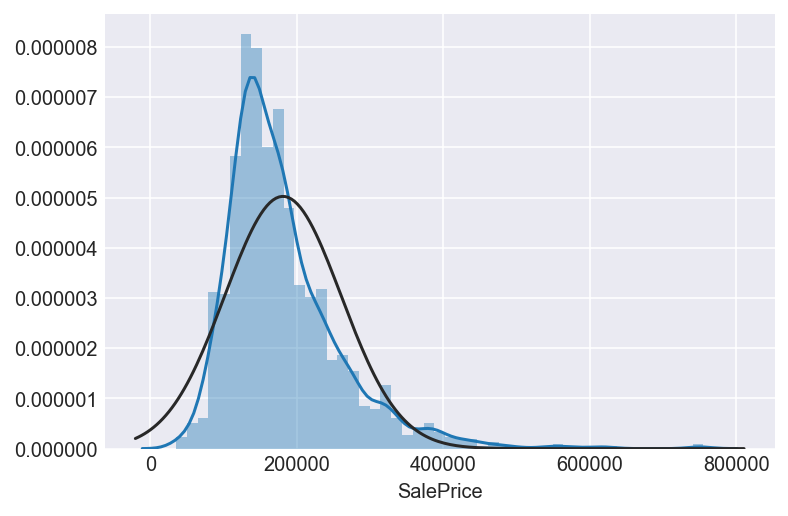

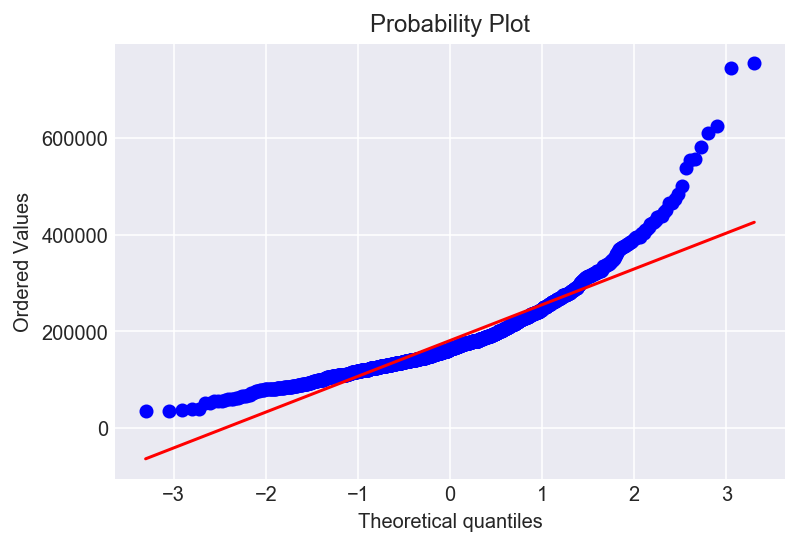

In [5]:
def check_skewness(col):
    """ Plot distribution and descriptive stats"""
    sns.distplot(train[col] , fit=norm);
    fig = plt.figure()
    res = stats.probplot(train[col], plot=plt)
    
    # Get the fitted parameters used by the function
    (mean, stddev) = norm.fit(train[col])
    print( '\n mean = {:.2f} and stddev = {:.2f}\n'.format(mean, stddev))
check_skewness('SalePrice')

Our target looks positively skewed based on the histogram, kde, and QQ plot. Next, let's look at the distribution and correlation of some of the more import features.

We'll select only features with a correlation coefficeint with a magnitude greater than .5; we generally get the most information and predictive power from these features.

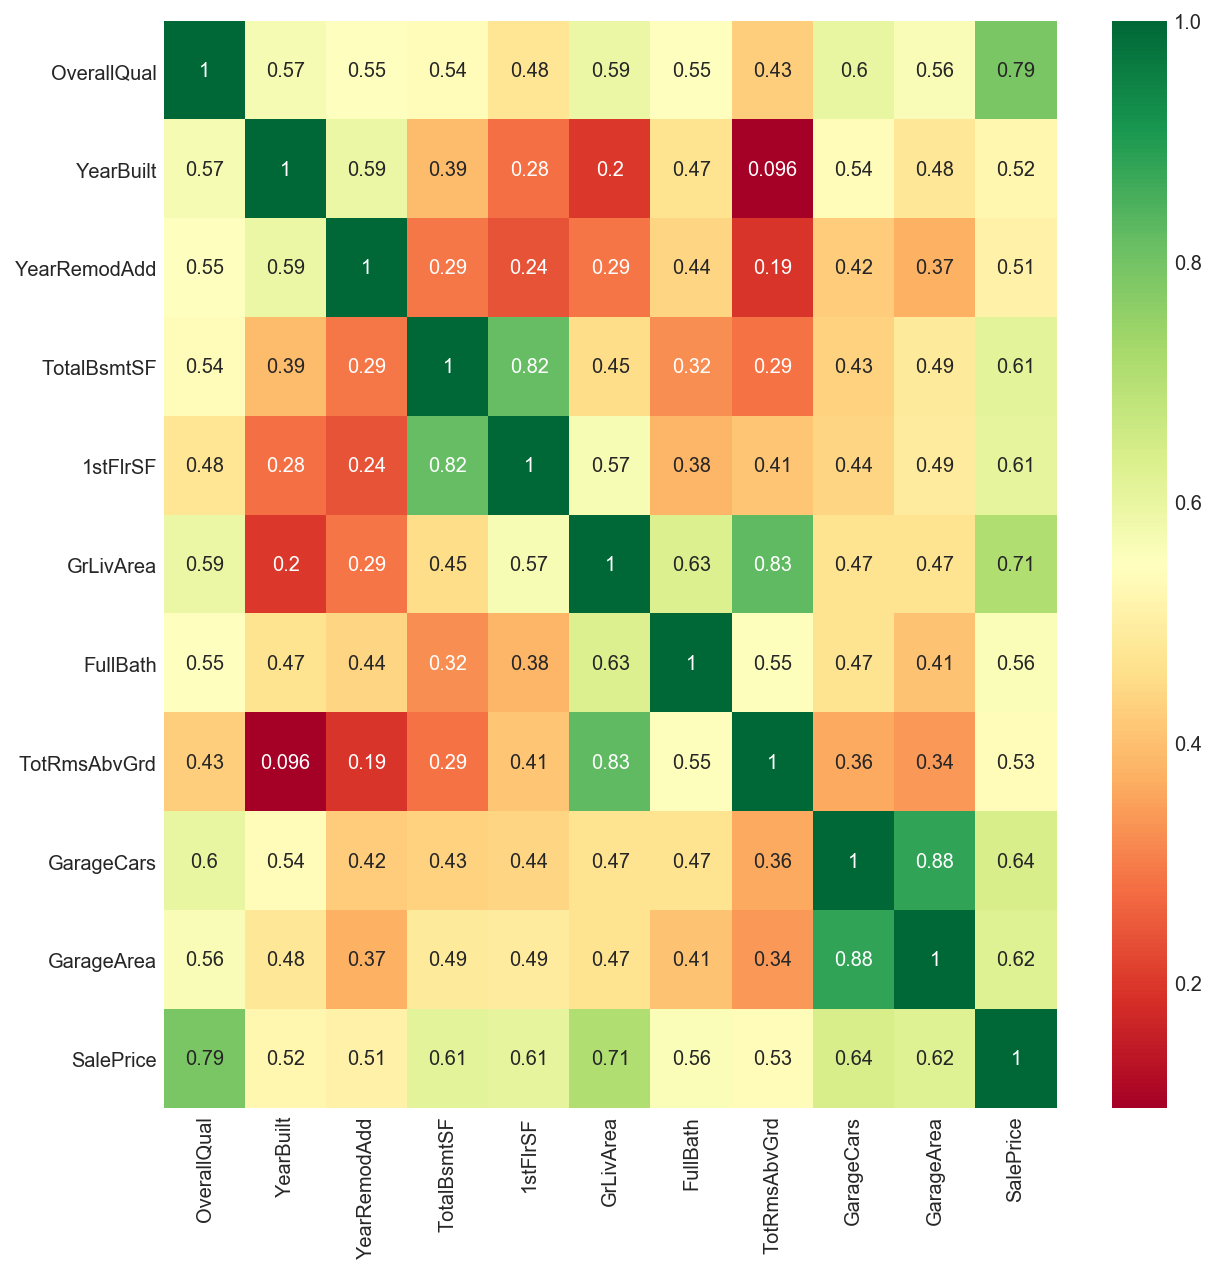

In [6]:
corrmat = train.corr()
top_corr_features = corrmat.index[abs(corrmat["SalePrice"])>0.5]
plt.figure(figsize=(10,10))
g = sns.heatmap(train[top_corr_features].corr(),annot=True,cmap="RdYlGn")

Below we can see the bivariate scatter plots as well as univariate distributions for all of the features most highly correlated with our target.
Looking at the top row, we can see that our target is positively skewed and that all of these features are positively correlated with our target, as well as with each other in most cases displayed here.

Also, looking at the diagonal we can see that most of these features are approximately normal distributed. We will end up standardizing the skewed features later on to improve the performance of the model.

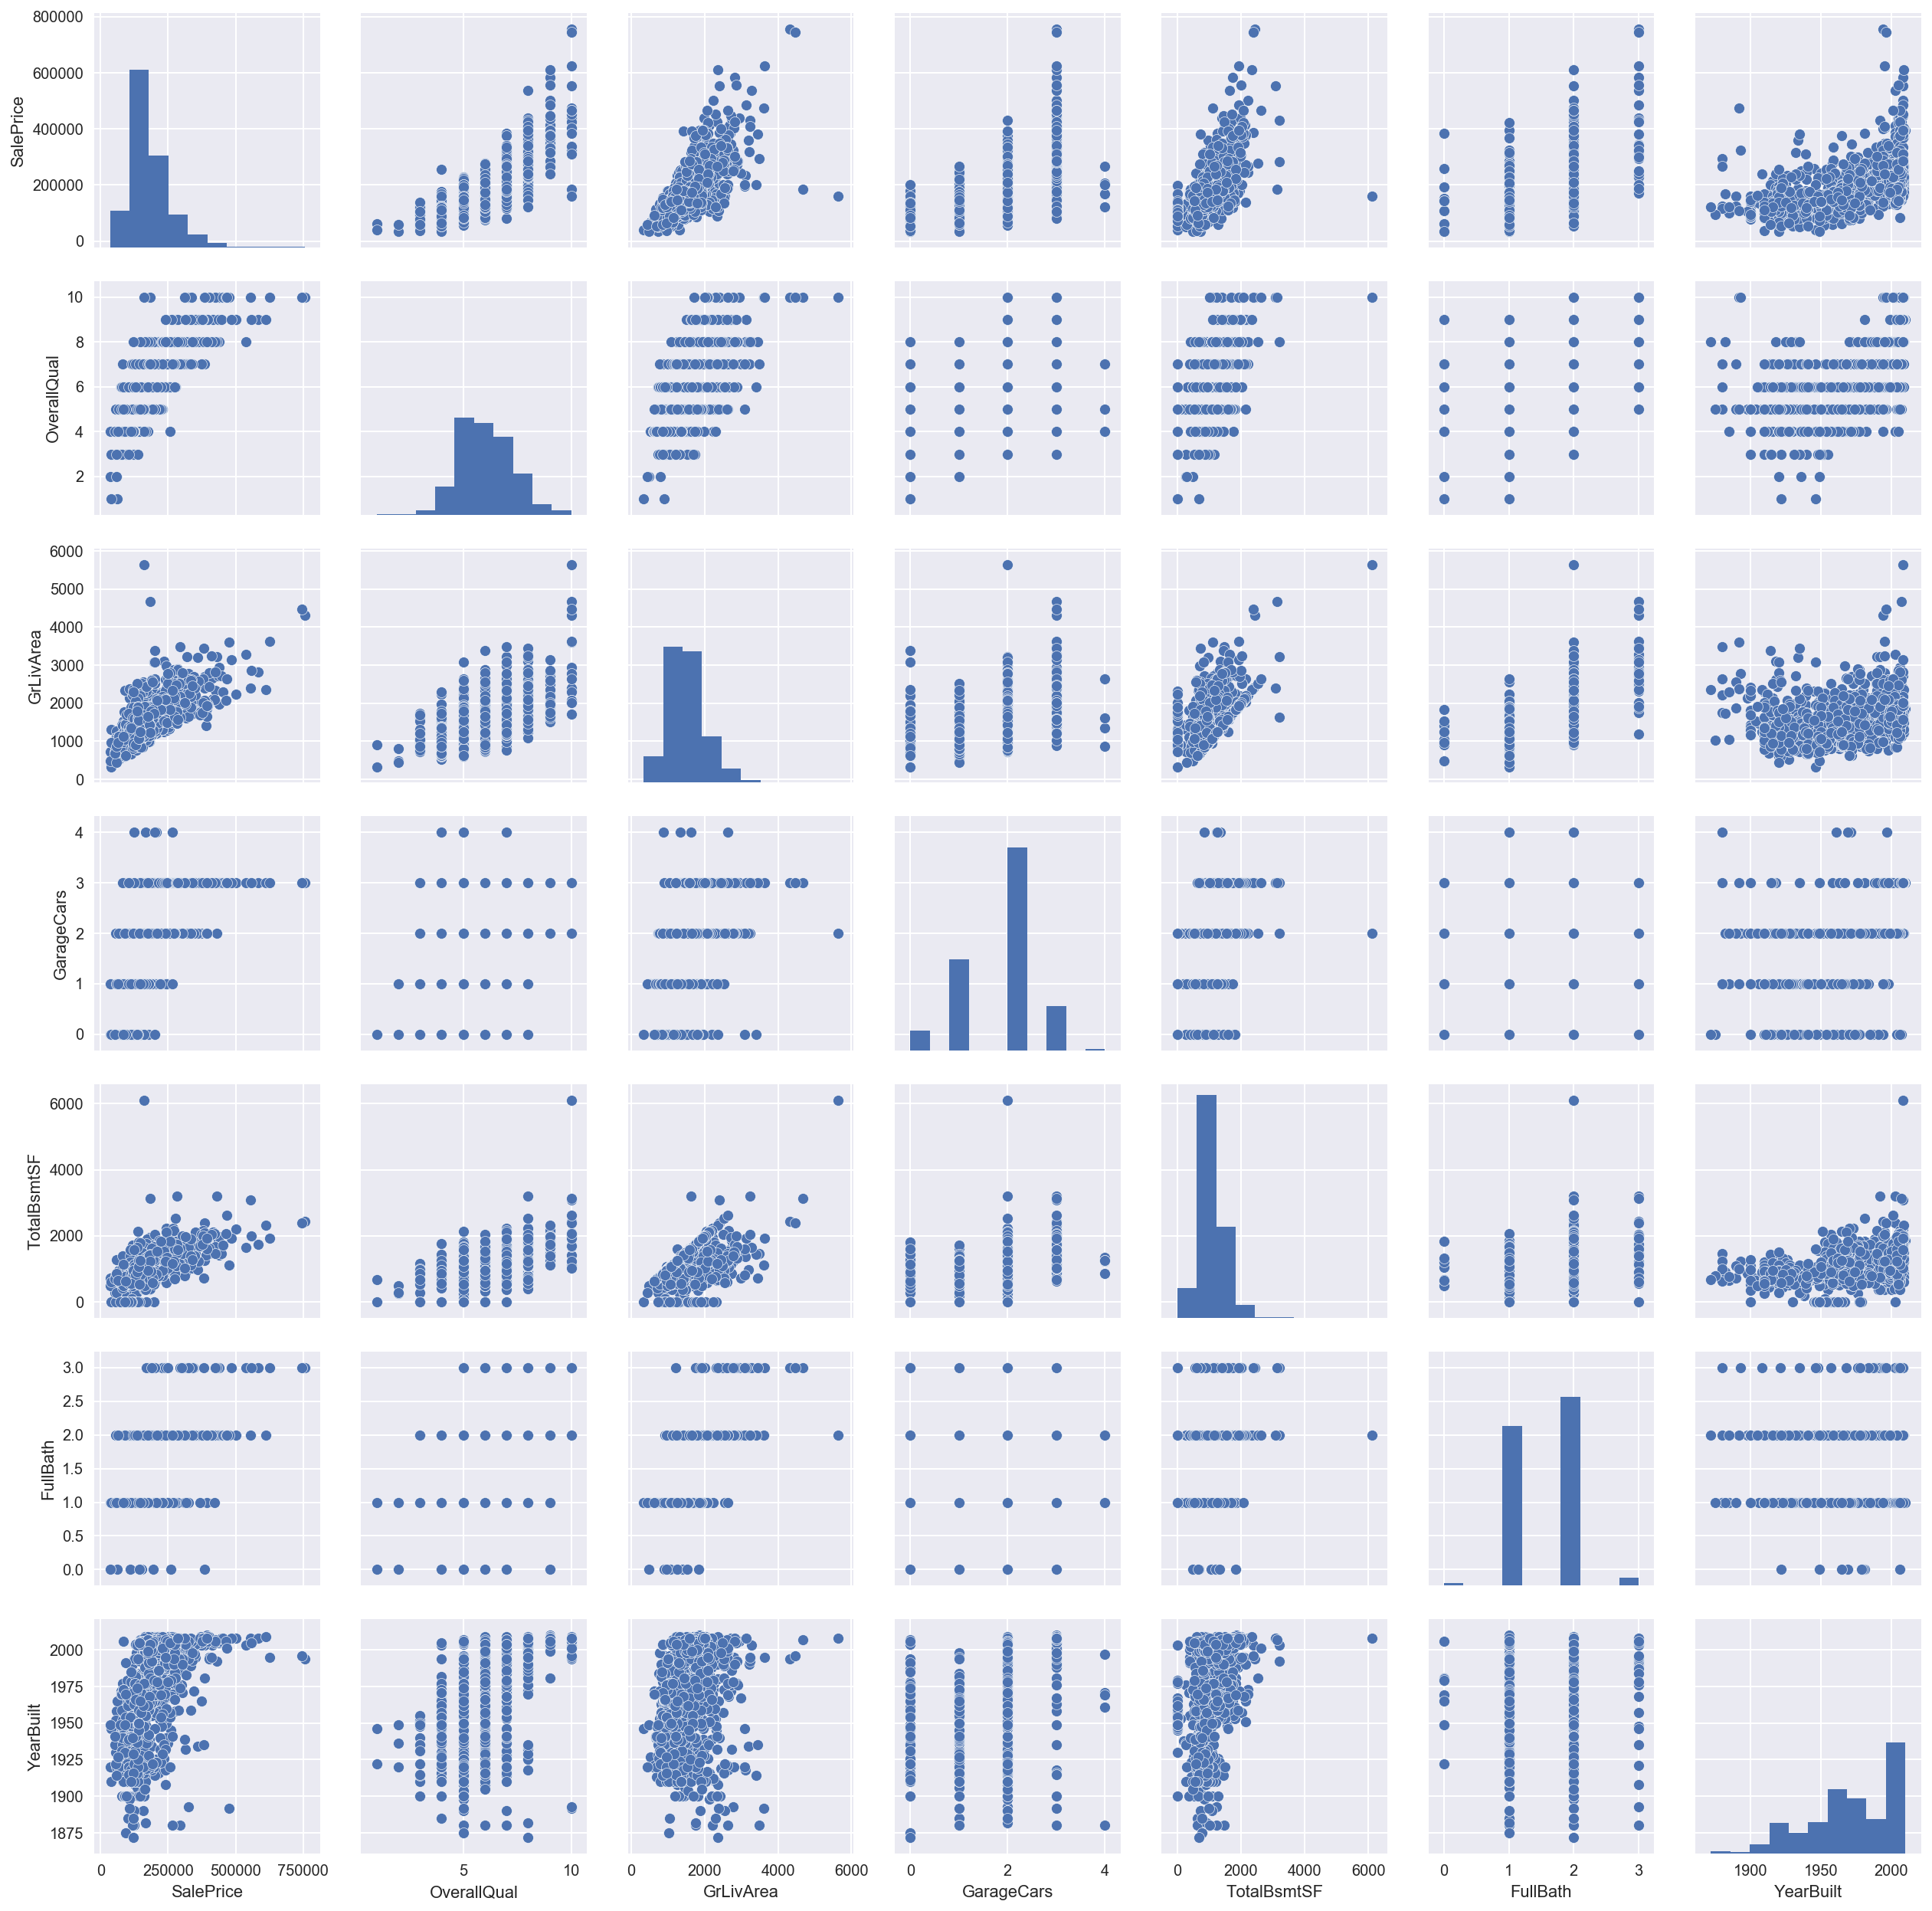

In [7]:
sns.set()
cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt']
sns.pairplot(train[cols], size = 2.5)


We can see from both the plot above and below that the OverallQual feature has a strong positive non-linear correlation with our target, SalePrice. Also, all of the other varibles above have strong correlations with our target.

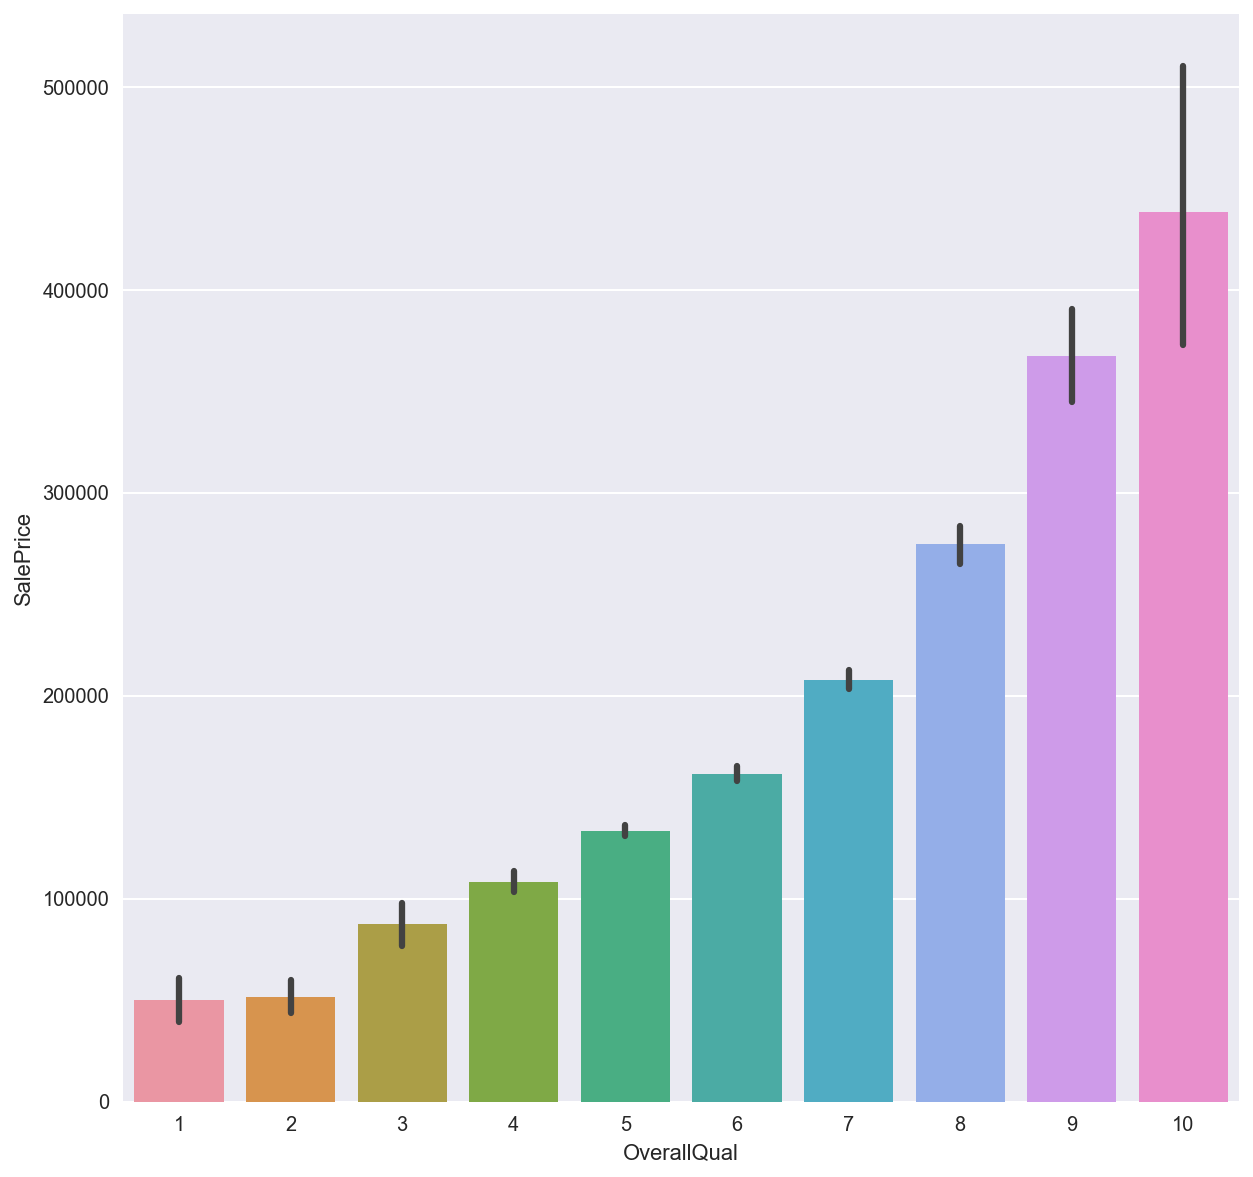

In [8]:
plt.figure(figsize=(10,10))
sns.barplot(train.OverallQual,train.SalePrice)

Let's see if we can do some cleaning using two of our features most highly correlated with the trget: GrLivArea and OverallQual.

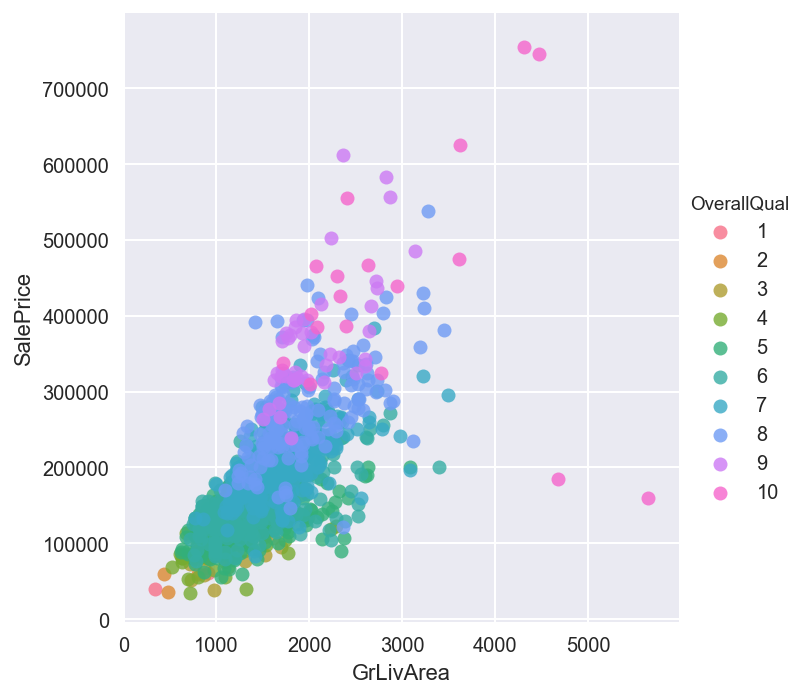

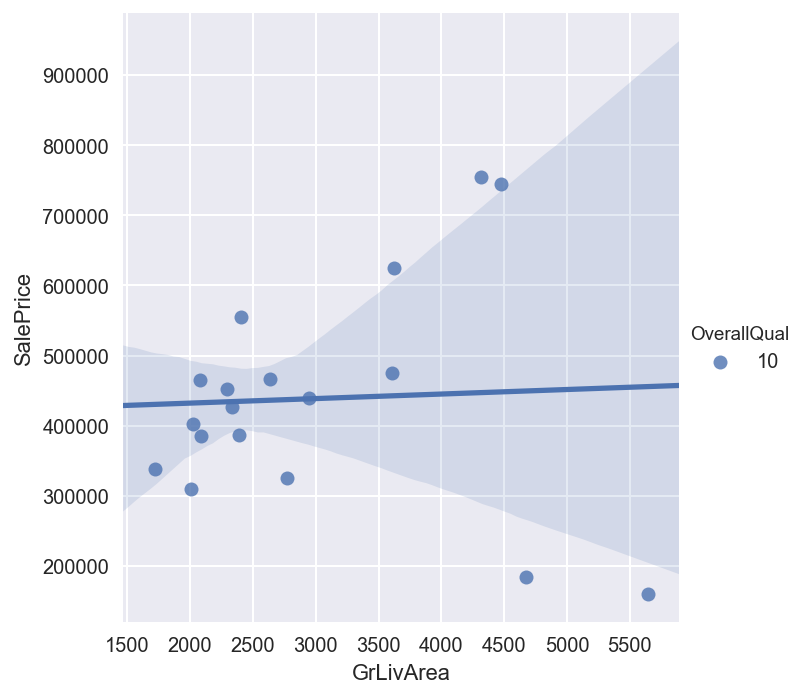

In [9]:
graph1 =    sns.lmplot(x = 'GrLivArea', 
                       y = 'SalePrice',
                       hue = 'OverallQual', 
                       data = train,
                       fit_reg = False)

graph2 =    sns.lmplot(x = 'GrLivArea', 
                       y = 'SalePrice',
                       hue = 'OverallQual', 
                       data = train[train['OverallQual'] == 10],
                       fit_reg = True)


When grouped by overall house quality, we can see two outliers that clearly don't follow the relationship between price and living area; we drop these observations below.

In [10]:
train = train.loc[(train['GrLivArea'] < 4000) | (train['SalePrice'] > 600000) ,:]

## Restructure data and continuing cleaning

Let's continue cleaning our features. 

At this point we will seperate our features from our target, since we have no more cleaning to do on our target before we build our model.

In [11]:
ntrain = train.shape[0]
ntest = test.shape[0]

# target values to train with
y_train = train['SalePrice'].values

One remark is that below we will be stacking our training and test data into one dataset that we will use for all imputation.

On a real project, we wouldn't have the luxury of imputing based on our test data, so in a way we are creating a data leakage problem and we could be overfitting to our test data, but for now we will carry on for two reasons: one, we will assume that the more data we have, the more accurate our imputation techniques will be, and two, we need to impute the test data for our submission file. 

We can check the validity of the first assumption by creating a different dataset and model, free of the data linkage problem, and comparing it's result with the results from this model, using the kaggle leaderboard.


In [12]:
# concatenate train and test and drop target so we can impute all x values, 
# instead of just x-vals from train
all_data = pd.concat((train, test)).reset_index(drop=True)
all_data.drop(['SalePrice'], axis=1, inplace=True)

# look at size of all data
print("all_data size is : {}".format(all_data.shape))

all_data size is : (2917, 79)


### Missing data and imputation 

Before we start imputing, we will get an idea of how much missing data we have overall.

In [13]:
def missing_data_counts(data):
    all_data_na = (data.isnull().sum() / len(data)) * 100
    all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)
    return all_data_na, pd.DataFrame({'Missing Ratio' : all_data_na})

In [14]:
all_data_na = missing_data_counts(all_data)[0]
missing_data_counts(all_data)[1]

Missing Ratio
PoolQC            99.691464
MiscFeature       96.400411
Alley             93.212204
Fence             80.425094
FireplaceQu       48.680151
LotFrontage       16.660953
GarageQual         5.450806
GarageCond         5.450806
GarageFinish       5.450806
GarageYrBlt        5.450806
GarageType         5.382242
BsmtExposure       2.811107
BsmtCond           2.811107
BsmtQual           2.776826
BsmtFinType2       2.742544
BsmtFinType1       2.708262
MasVnrType         0.822763
MasVnrArea         0.788481
MSZoning           0.137127
BsmtFullBath       0.068564
BsmtHalfBath       0.068564
Utilities          0.068564
Functional         0.068564
Electrical         0.034282
BsmtUnfSF          0.034282
Exterior1st        0.034282
Exterior2nd        0.034282
TotalBsmtSF        0.034282
GarageArea         0.034282
GarageCars         0.034282
BsmtFinSF2         0.034282
BsmtFinSF1         0.034282
KitchenQual        0.034282
SaleType           0.034282

Text(0.5,1,'Percent missing data by feature')

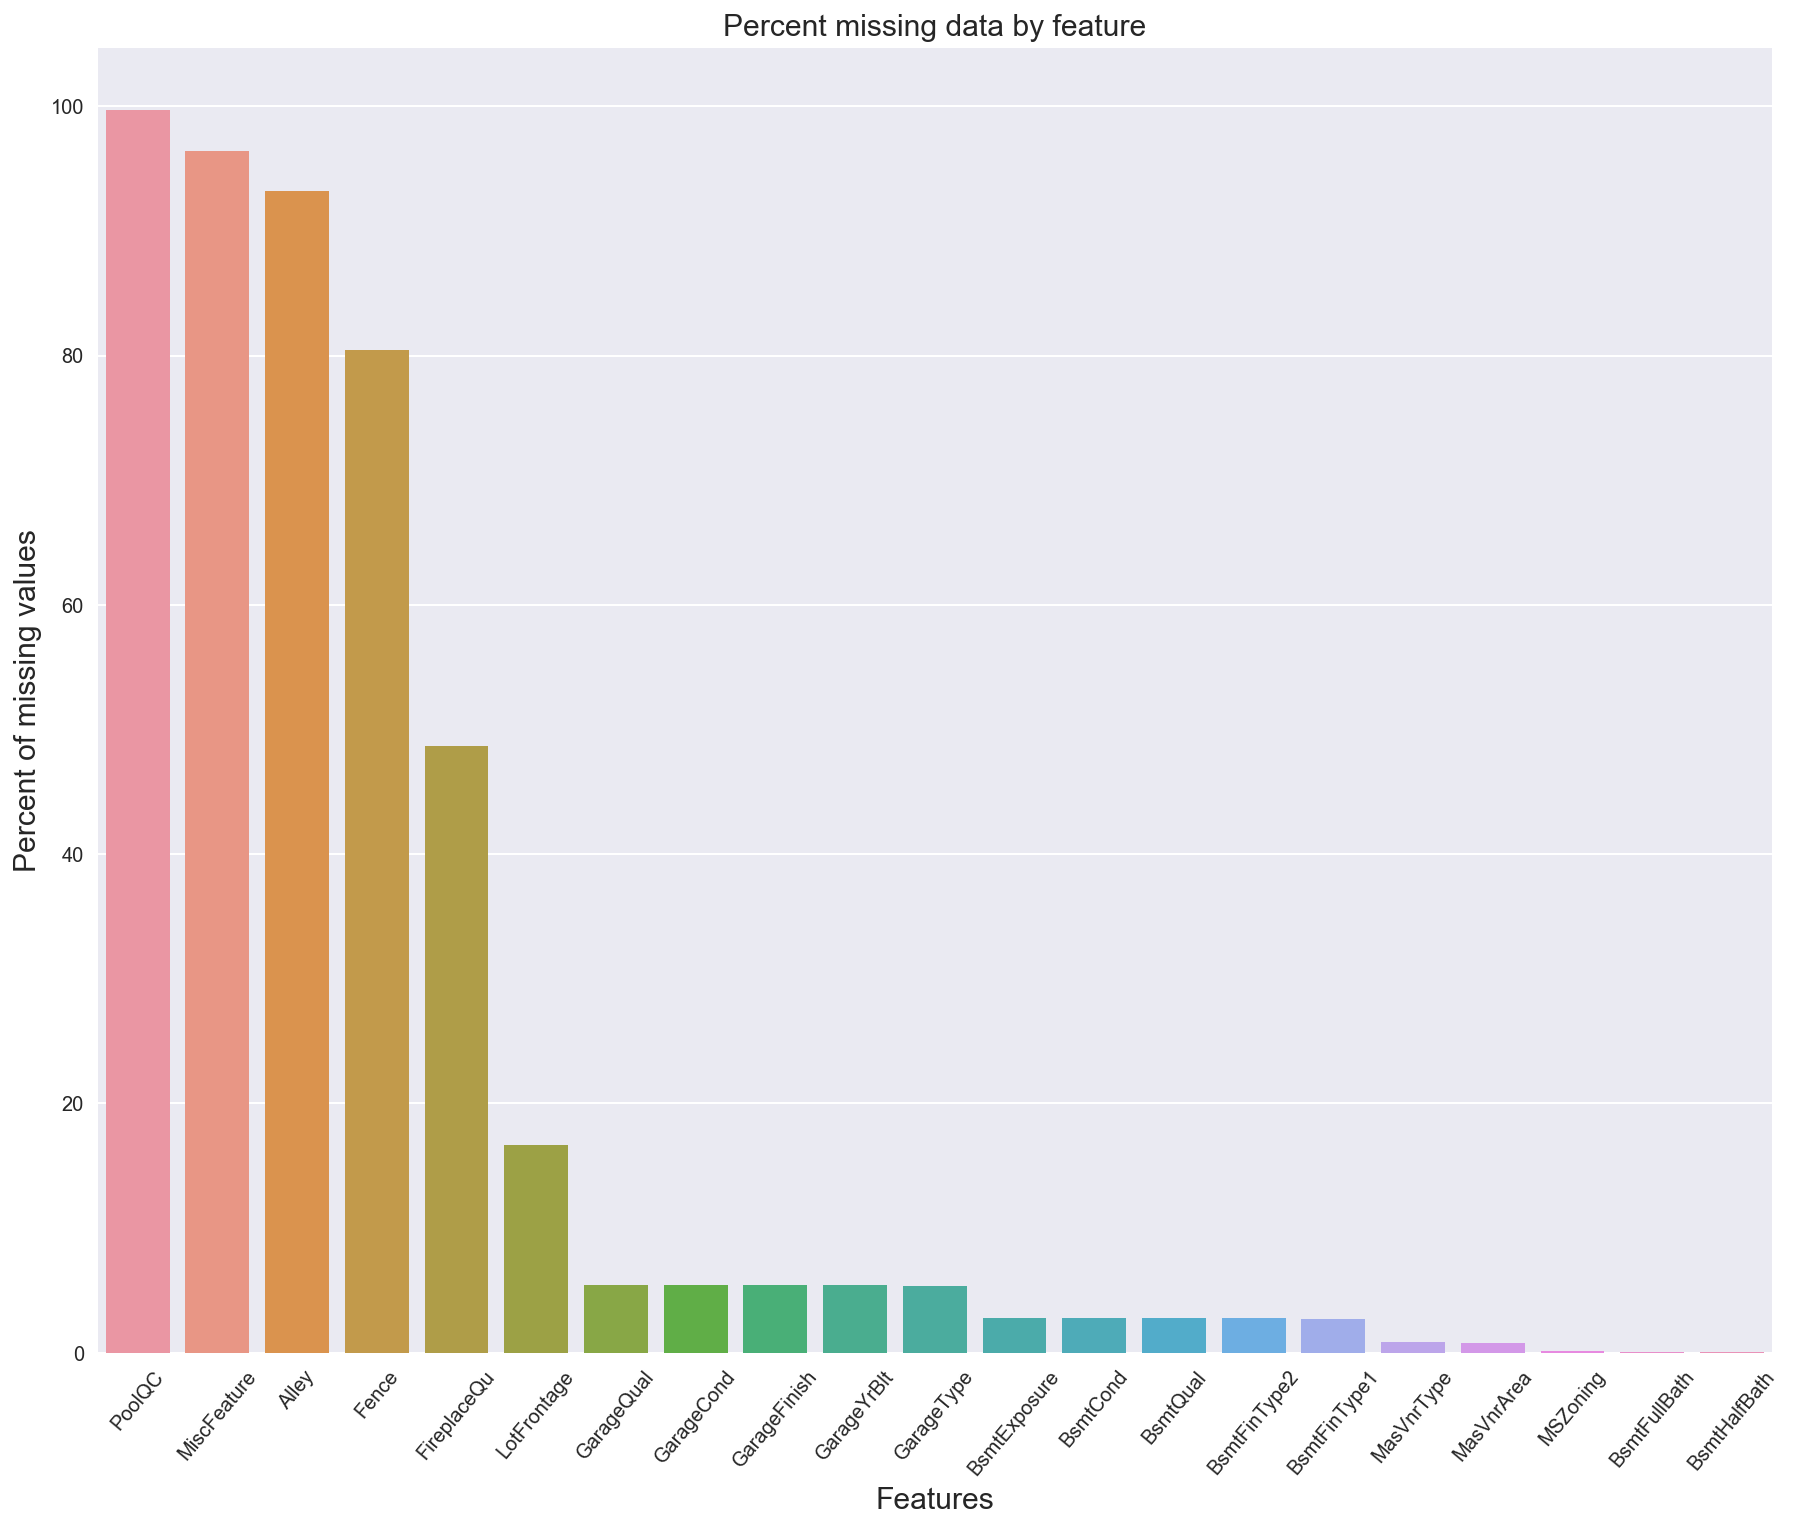

In [16]:
f, ax = plt.subplots(figsize=(15, 12))
plt.xticks(rotation='50')
sns.barplot(x=all_data_na[:21].index, y=all_data_na[:21])
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature', fontsize=15)


Wow, some of our features have a lot of missing values!. Look below for counts in addition to the missing rates above.

In [17]:
missing_data = pd.DataFrame({'Missing Ratio' : all_data_na, 'Missing Count': all_data.isnull().sum()[all_data.isnull().any()]})
missing_data.sort_values(by = 'Missing Ratio', ascending = False)

Missing Ratio  Missing Count
PoolQC            99.691464           2908
MiscFeature       96.400411           2812
Alley             93.212204           2719
Fence             80.425094           2346
FireplaceQu       48.680151           1420
LotFrontage       16.660953            486
GarageCond         5.450806            159
GarageQual         5.450806            159
GarageYrBlt        5.450806            159
GarageFinish       5.450806            159
GarageType         5.382242            157
BsmtExposure       2.811107             82
BsmtCond           2.811107             82
BsmtQual           2.776826             81
BsmtFinType2       2.742544             80
BsmtFinType1       2.708262             79
MasVnrType         0.822763             24
MasVnrArea         0.788481             23
MSZoning           0.137127              4
Utilities          0.068564              2
Functional         0.068564              2
BsmtHalfBath       0.068564              2
BsmtFullBath       0.068564              2
GarageCars         0.034282              1
Exterior2nd        0.034282              1
Exterior1st        0.034282              1
KitchenQual        0.034282              1
Electrical         0.034282              1
BsmtUnfSF          0.034282              1
BsmtFinSF2         0.034282              1
BsmtFinSF1         0.034282              1
SaleType           0.034282              1
TotalBsmtSF        0.034282              1
GarageArea         0.034282              1

Also, below we can see the nullity correlation between features. The blank squares imply a correlation coefficient of close to 0. 

It is interesting to see the pairs with correlation of one that are not on the diagonal; these feature pairs/combinations have all of their missing values in the same rows, we will come back to these later. Also, highly correlated missing features could be clues on how to impute data.

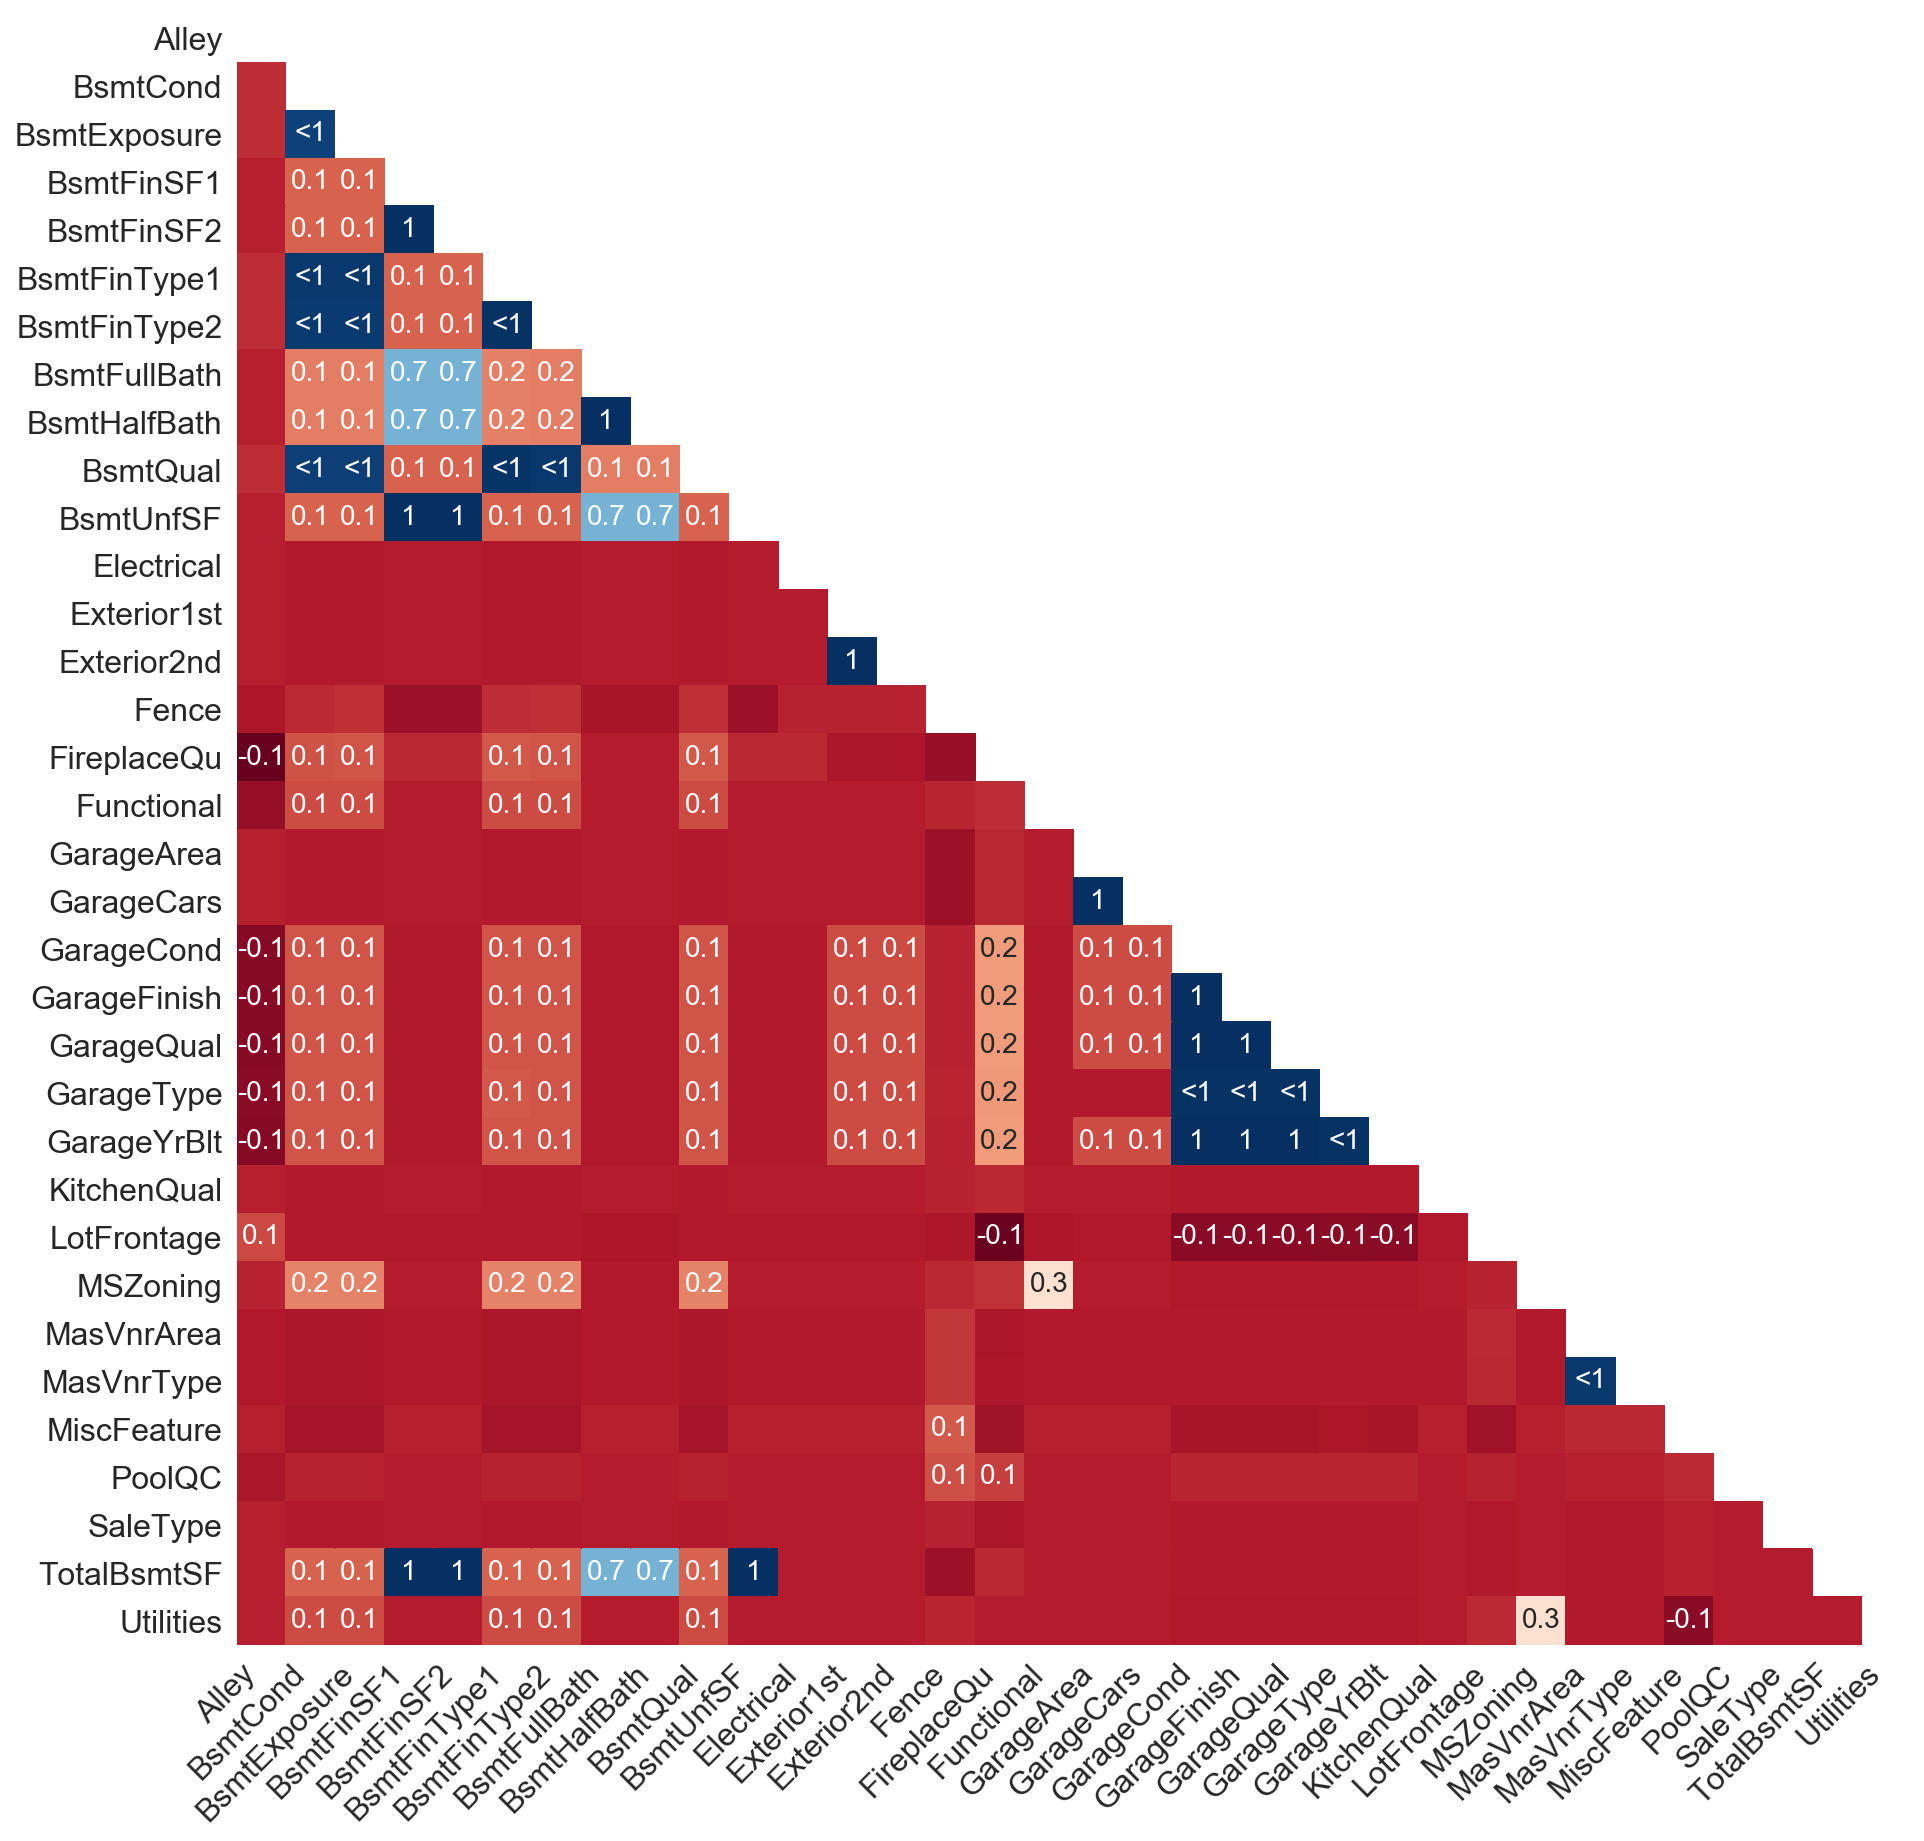

In [18]:
msno.heatmap(all_data[all_data.isnull().sum()[all_data.isnull().any()].index], figsize=(15, 15))

In [19]:
missing_vals_str = train.select_dtypes(include = ['object']).isna().sum()
missing_vals_str[missing_vals_str != 0].sort_values(ascending=False)

PoolQC          1452
MiscFeature     1404
Alley           1367
Fence           1177
FireplaceQu      690
GarageCond        81
GarageQual        81
GarageFinish      81
GarageType        81
BsmtFinType2      38
BsmtExposure      38
BsmtFinType1      37
BsmtCond          37
BsmtQual          37
MasVnrType         8
Electrical         1
dtype: int64

### Imputation for features with high frequency of data missing at random (MAR)

#### PoolQC imputation

We can see the 9 out of 2717 non missing values for PoolQC below. 4 excellent, 3 good and 2 fair. 

In [20]:
all_data['PoolQC'].value_counts(dropna = False)

NaN    2908
Ex        4
Gd        3
Fa        2
Name: PoolQC, dtype: int64

We have no info from other features to confidently impute missing values for this feature, so we will assume they do not have a pool and impute with none.

In [21]:
all_data["PoolQC"] = all_data["PoolQC"].fillna("None")

We will follow the same procedure for the following features with string values; if there doesn't seem to be other features that can be used as indicators for informed imputation, we will assume the house has no such featureand impute 'None'.

#### MiscFeature imputation

In [22]:
all_data['MiscFeature'].value_counts(dropna = False)

NaN     2812
Shed      95
Gar2       5
Othr       4
TenC       1
Name: MiscFeature, dtype: int64

In [23]:
# MiscFeature missing at random, no info from other features--impute with 'None'
all_data["MiscFeature"] = all_data["MiscFeature"].fillna("None")

#### Alley

In [24]:
all_data['Alley'].value_counts(dropna = False)

NaN     2719
Grvl     120
Pave      78
Name: Alley, dtype: int64

In [25]:
# Alley missing at random, no info from other features--impute with 'None'
all_data["Alley"] = all_data["Alley"].fillna("None")

#### Fence

In [26]:
all_data['Fence'].value_counts(dropna = False)

NaN      2346
MnPrv     329
GdPrv     118
GdWo      112
MnWw       12
Name: Fence, dtype: int64

In [27]:
# Fence missing at random, no info from other features--impute with 'None'
all_data["Fence"] = all_data["Fence"].fillna("None")

#### FireplaceQu

In [28]:
all_data['FireplaceQu'].value_counts(dropna = False)

NaN    1420
Gd      742
TA      592
Fa       74
Po       46
Ex       43
Name: FireplaceQu, dtype: int64

In [29]:
# Fireplace quality missing at random, no info from other features--impute with 'None'
all_data["FireplaceQu"] = all_data["FireplaceQu"].fillna("None")

### LotFrontage imputation

Next, let's work on the imputation for some continous features. 

Below we will begin by looking at the "LotFrontage" (Linear feet of street connected to property) feature.


In [30]:
# Grouping by Neighborhood and Check the LotFrontage. Most of the grouping has similar areas
grouped_df = all_data.groupby('Neighborhood')['LotFrontage']

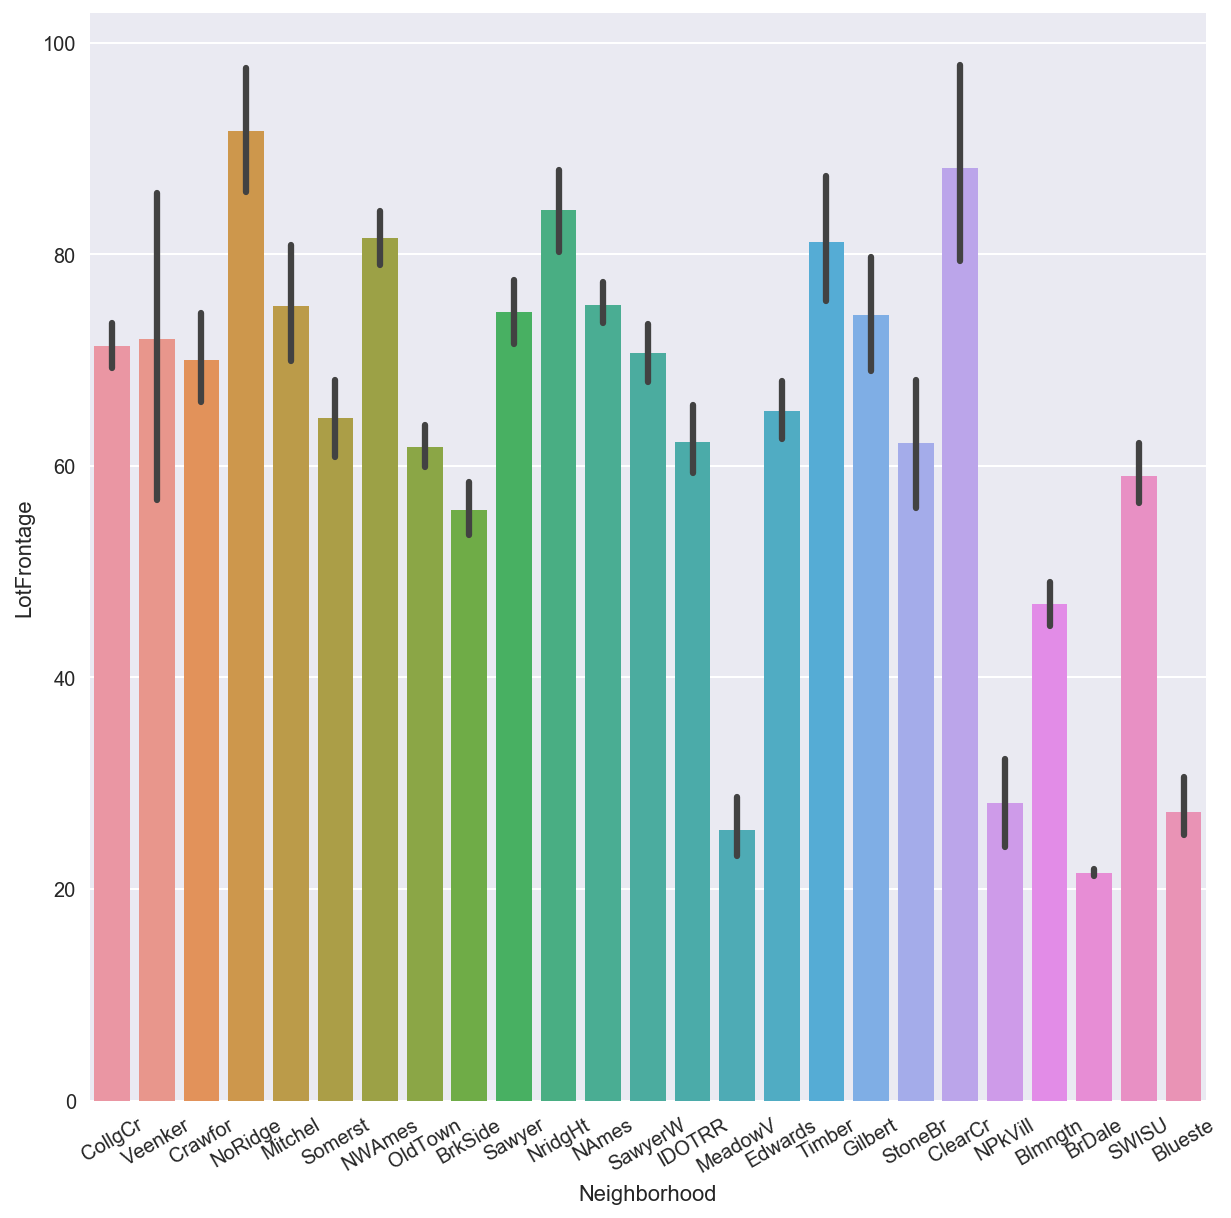

In [31]:
plt.figure(figsize=(10,10))
g= sns.barplot(all_data['Neighborhood'],all_data['LotFrontage'])
g = g.set_xticklabels(g.get_xticklabels(),rotation=30)

We can see that the average lot frontage varies greatly between neighborhoods but has fairly tight ranges within neighborhoods. This is intuitive as property sizes within neighborhood tend to be similar.

In [32]:
#Group by neighborhood and fill in missing value by the median LotFrontage of all the neighborhood
all_data["LotFrontage"] = all_data.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))

### Garage feature imputation

Next we will address all garage features, which contain both numerical and categorical data.

In [33]:
# Create a list of all garage related features
garage_cols = [col for col in all_data if col.startswith('Garage')]

for feat in garage_cols:
    print("{} has {} missing values".format(feat, all_data[feat].isnull().sum()))

GarageArea has 1 missing values
GarageCars has 1 missing values
GarageCond has 159 missing values
GarageFinish has 159 missing values
GarageQual has 159 missing values
GarageType has 157 missing values
GarageYrBlt has 159 missing values


In [34]:
# Create an index for all obs with at least one missing garage related value
miss_gar_inds = pd.isnull(all_data[garage_cols]).any(1).nonzero()[0]

Below we will plot missing values in a graph and table; missing values in the graph are represented by thin light grey/white rectangles and as -99 in the table.

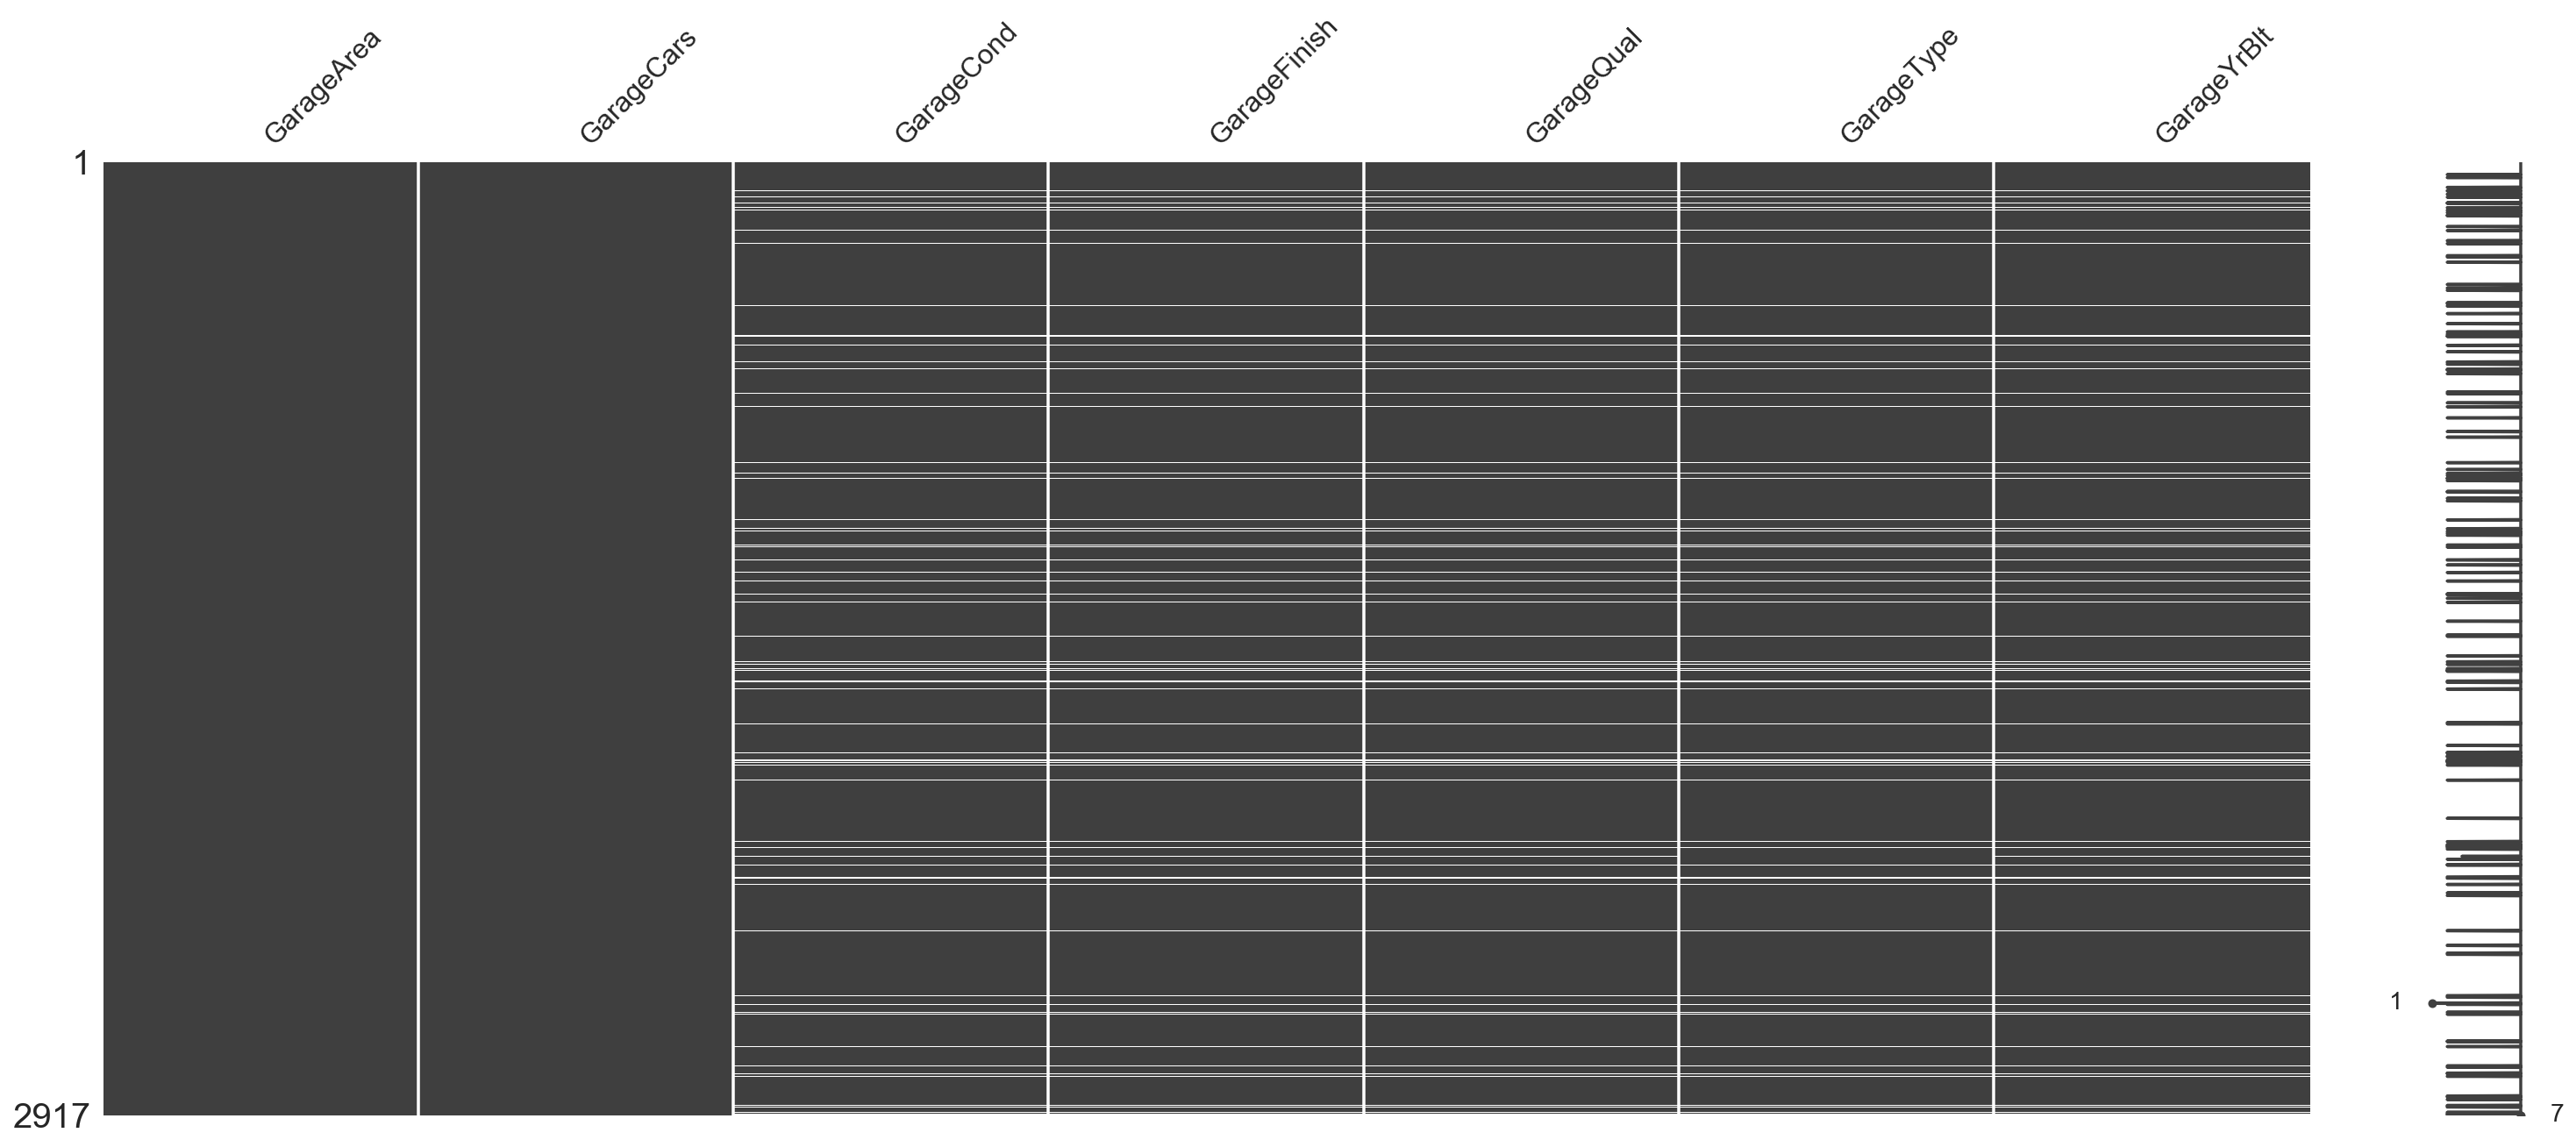

In [35]:
msno.matrix(all_data[garage_cols])

In [36]:
all_data2 = all_data.copy().fillna(-99)
all_data2.iloc[miss_gar_inds].groupby(garage_cols)[garage_cols].count()

GarageArea  \
GarageArea GarageCars GarageCond GarageFinish GarageQual GarageType GarageYrBlt               
-99.0      -99.0      -99        -99          -99        Detchd     -99.0                 1   
 0.0        0.0       -99        -99          -99        -99        -99.0               157   
 360.0      1.0       -99        -99          -99        Detchd     -99.0                 1   

                                                                                 GarageCars  \
GarageArea GarageCars GarageCond GarageFinish GarageQual GarageType GarageYrBlt               
-99.0      -99.0      -99        -99          -99        Detchd     -99.0                 1   
 0.0        0.0       -99        -99          -99        -99        -99.0               157   
 360.0      1.0       -99        -99          -99        Detchd     -99.0                 1   

                                                                                 GarageCond  \
GarageArea GarageCars GarageCond GarageFinish GarageQual GarageType GarageYrBlt               
-99.0      -99.0      -99        -99          -99        Detchd     -99.0                 1   
 0.0        0.0       -99        -99          -99        -99        -99.0               157   
 360.0      1.0       -99        -99          -99        Detchd     -99.0                 1   

                                                                                 GarageFinish  \
GarageArea GarageCars GarageCond GarageFinish GarageQual GarageType GarageYrBlt                 
-99.0      -99.0      -99        -99          -99        Detchd     -99.0                   1   
 0.0        0.0       -99        -99          -99        -99        -99.0                 157   
 360.0      1.0       -99        -99          -99        Detchd     -99.0                   1   

                                                                                 GarageQual  \
GarageArea GarageCars GarageCond GarageFinish GarageQual GarageType GarageYrBlt               
-99.0      -99.0      -99        -99          -99        Detchd     -99.0                 1   
 0.0        0.0       -99        -99          -99        -99        -99.0               157   
 360.0      1.0       -99        -99          -99        Detchd     -99.0                 1   

                                                                                 GarageType  \
GarageArea GarageCars GarageCond GarageFinish GarageQual GarageType GarageYrBlt               
-99.0      -99.0      -99        -99          -99        Detchd     -99.0                 1   
 0.0        0.0       -99        -99          -99        -99        -99.0               157   
 360.0      1.0       -99        -99          -99        Detchd     -99.0                 1   

                                                                                 GarageYrBlt  
GarageArea GarageCars GarageCond GarageFinish GarageQual GarageType GarageYrBlt               
-99.0      -99.0      -99        -99          -99        Detchd     -99.0                  1  
 0.0        0.0       -99        -99          -99        -99        -99.0                157  
 360.0      1.0       -99        -99          -99        Detchd     -99.0                  1

We can infer that the home doesn't have a garage when all of our garage features are missing at the same time. 

It seems like we have a difference in how missing is being represented for numeric garage features (GarageArea and GarageCars) and categorical garage features. But since we have 0 for most missing numeric values and truly missing for most missing categorical values, let's impute all missing with 'None' for categorical features and 0 for numerical features.Basement features have similar missing patterns to our garage features, so will use the same logic and imputation techniques. We can infer that the home doesn't have a garage when all of our garage features are missing at the same time. 


In [37]:
# Impute categorical features with 'None'
for col in ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']:
    all_data[col] = all_data[col].fillna('None')
    
# Impute numeric features with 0
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    all_data[col] = all_data[col].fillna(0)

### Basement feature imputation

Basement features have similar missing patterns to our garage features, so will use the same logic and imputation techniques.

In [38]:
# Create a list of all basement related features
bsmt_cols = [col for col in all_data if col.startswith('Bsmt')]

for feat in bsmt_cols:
    print("{} has {} missing values".format(feat, all_data[feat].isna().sum()))

BsmtCond has 82 missing values
BsmtExposure has 82 missing values
BsmtFinSF1 has 1 missing values
BsmtFinSF2 has 1 missing values
BsmtFinType1 has 79 missing values
BsmtFinType2 has 80 missing values
BsmtFullBath has 2 missing values
BsmtHalfBath has 2 missing values
BsmtQual has 81 missing values
BsmtUnfSF has 1 missing values


In [39]:
# Create an index for all obs with at least one missing basement related value
miss_bsmt_inds = pd.isnull(all_data[bsmt_cols]).any(1).nonzero()[0]

Below we will plot missing values in a graph and table; missing values in the graph are represented by then light grey/white rectangles and as -99 in the table.


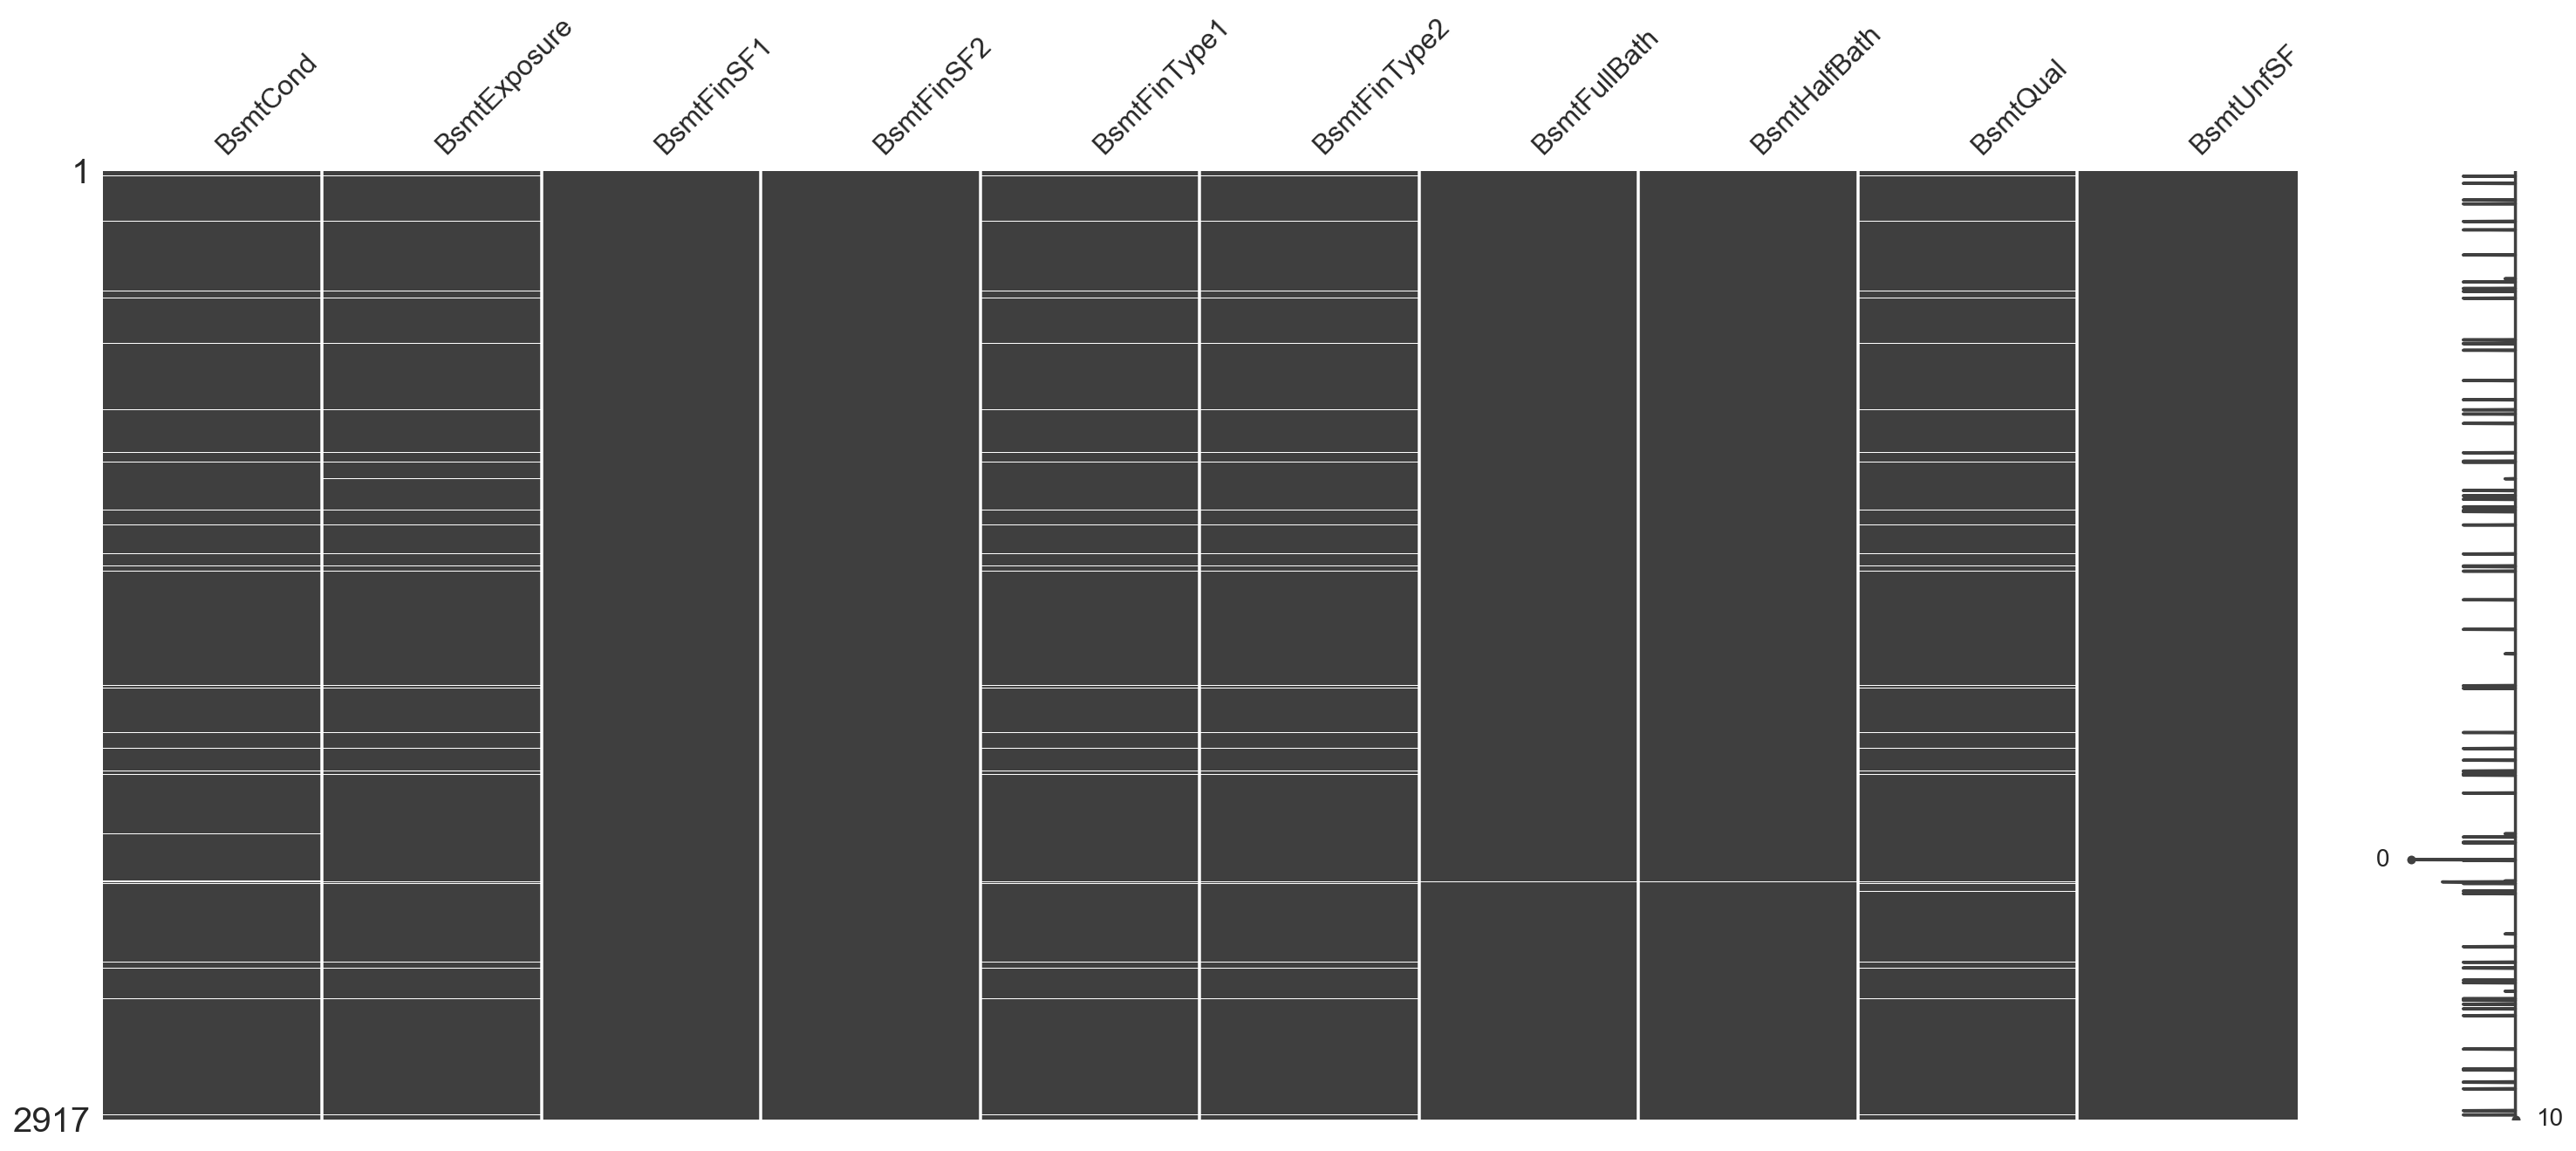

In [40]:
msno.matrix(all_data[bsmt_cols]) 

In [41]:
all_data2.iloc[miss_bsmt_inds].groupby(bsmt_cols)[bsmt_cols].count()

BsmtCond  \
BsmtCond BsmtExposure BsmtFinSF1 BsmtFinSF2 BsmtFinType1 BsmtFinType2 BsmtFullBath BsmtHalfBath BsmtQual BsmtUnfSF             
-99      -99          -99.0      -99.0      -99          -99          -99.0        -99.0        -99      -99.0             1   
                       0.0        0.0       -99          -99          -99.0        -99.0        -99       0.0              1   
                                                                       0.0          0.0         -99       0.0             77   
         Av            755.0      0.0       ALQ          Unf           0.0          0.0         TA        240.0            1   
         Mn            1044.0     382.0     GLQ          Rec           1.0          0.0         Gd        0.0              1   
         No            1033.0     0.0       BLQ          Unf           0.0          1.0         TA        94.0             1   
Fa       No            0.0        0.0       Unf          Unf           0.0          0.0         -99       173.0            1   
TA       -99           0.0        0.0       Unf          Unf           0.0          0.0         Gd        725.0            1   
                                                                                                          936.0            1   
                                                                                                          1595.0           1   
         No            0.0        0.0       Unf          Unf           0.0          0.0         -99       356.0            1   
                       1124.0     479.0     GLQ          -99           1.0          0.0         Gd        1603.0           1   

                                                                                                                    BsmtExposure  \
BsmtCond BsmtExposure BsmtFinSF1 BsmtFinSF2 BsmtFinType1 BsmtFinType2 BsmtFullBath BsmtHalfBath BsmtQual BsmtUnfSF                 
-99      -99          -99.0      -99.0      -99          -99          -99.0        -99.0        -99      -99.0                 1   
                       0.0        0.0       -99          -99          -99.0        -99.0        -99       0.0                  1   
                                                                       0.0          0.0         -99       0.0                 77   
         Av            755.0      0.0       ALQ          Unf           0.0          0.0         TA        240.0                1   
         Mn            1044.0     382.0     GLQ          Rec           1.0          0.0         Gd        0.0                  1   
         No            1033.0     0.0       BLQ          Unf           0.0          1.0         TA        94.0                 1   
Fa       No            0.0        0.0       Unf          Unf           0.0          0.0         -99       173.0                1   
TA       -99           0.0        0.0       Unf          Unf           0.0          0.0         Gd        725.0                1   
                                                                                                          936.0                1   
                                                                                                          1595.0               1   
         No            0.0        0.0       Unf          Unf           0.0          0.0         -99       356.0                1   
                       1124.0     479.0     GLQ          -99           1.0          0.0         Gd        1603.0               1   

                                                                                                                    BsmtFinSF1  \
BsmtCond BsmtExposure BsmtFinSF1 BsmtFinSF2 BsmtFinType1 BsmtFinType2 BsmtFullBath BsmtHalfBath BsmtQual BsmtUnfSF               
-99      -99          -99.0      -99.0      -99          -99          -99.0        -99.0        -99      -99.0               1   
                       0.0        0.0       -99          -99          -99.0        -

In [42]:
# Impute categorical features with 'None'
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    all_data[col] = all_data[col].fillna('None')
    
# Impute numeric features with 0
for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    all_data[col] = all_data[col].fillna(0)

### Masonry veneer feature imputation

Masonry veneer features have similar missing patterns to our garage and basement features, so will use the same logic and imputation techniques.

In [43]:
# Create a list of all basement related features
mas_cols = [col for col in all_data if col.startswith('Mas')]

for feat in mas_cols:
    print("{} has {} missing values".format(feat, all_data[feat].isna().sum()))

MasVnrArea has 23 missing values
MasVnrType has 24 missing values


In [44]:
# Create an index for all obs with at least one missing basement related value
miss_mas_inds = pd.isnull(all_data[mas_cols]).any(1).nonzero()[0]

In [45]:
all_data2.iloc[miss_mas_inds].groupby(mas_cols)[mas_cols].count()

MasVnrArea  MasVnrType
MasVnrArea MasVnrType                        
-99.0      -99                 23          23
 198.0     -99                  1           1

In [46]:
# Impute categorical features with 'None'
all_data["MasVnrType"] = all_data["MasVnrType"].fillna("None")
   
# Impute numeric features with 0
all_data["MasVnrArea"] = all_data["MasVnrArea"].fillna(0)

Let's check what features still have missing data

In [47]:
missing_vals_by_var = all_data.isna().sum()
missing_vals_by_var[all_data.isna().any()].sort_values(ascending=False)

MSZoning       4
Utilities      2
Functional     2
SaleType       1
KitchenQual    1
Exterior2nd    1
Exterior1st    1
Electrical     1
dtype: int64

### Imputation for features with low frequency of data missing completely at random (MCAR)

Next, we will impute values for our features with lower missinngness rates that seem like real missing values, as opposed to the missing values we infered were a result of the house not having a basement, garage, or masonry veneer.

#### MSZoning imputation

In [48]:
all_data['MSZoning'].value_counts(dropna = False)

RL         2263
RM          460
FV          139
RH           26
C (all)      25
NaN           4
Name: MSZoning, dtype: int64

In [49]:
# Impute missing values with mode; vast majority of houses have same MSZoning value
all_data['MSZoning'] = all_data['MSZoning'].fillna(all_data['MSZoning'].mode()[0])

#### Utilities imputation

In [50]:
all_data['Utilities'].value_counts(dropna = False)

AllPub    2914
NaN          2
NoSeWa       1
Name: Utilities, dtype: int64

All but one value is AllPub; this features provides us very little information to contribute to our model and it is incomplete, so we will drop it.


In [51]:
all_data = all_data.drop(['Utilities'], axis=1)

#### Functional imputation

In [52]:
all_data['Functional'].value_counts(dropna = False)

Typ     2715
Min2      70
Min1      65
Mod       35
Maj1      19
Maj2       9
Sev        2
NaN        2
Name: Functional, dtype: int64

In [53]:
# Impute missing values with 'Typ', which is both the mode and the baseline for this ordinal feature
all_data["Functional"] = all_data["Functional"].fillna("Typ")

Let's take a look at the four categorical features with 1 missing value.

In [54]:
mode_cols = ['Electrical','KitchenQual', 'Exterior1st', 'Exterior2nd', 'SaleType']

for feat in mode_cols:
    print("{} has {} missing values".format(feat, all_data[feat].isna().sum()))

Electrical has 1 missing values
KitchenQual has 1 missing values
Exterior1st has 1 missing values
Exterior2nd has 1 missing values
SaleType has 1 missing values


In [55]:
# Impute missing values with -99 to look for a pattern
miss_mode_inds = pd.isnull(all_data[mode_cols]).any(1).nonzero()[0]
all_data2.iloc[miss_mode_inds].groupby(mode_cols)[mode_cols].count()

Electrical  \
Electrical KitchenQual Exterior1st Exterior2nd SaleType               
-99        Gd          VinylSd     VinylSd     WD                 1   
SBrkr      -99         Wd Sdng     Wd Sdng     COD                1   
           Fa          -99         -99         WD                 1   
           TA          Plywood     Plywood     -99                1   

                                                         KitchenQual  \
Electrical KitchenQual Exterior1st Exterior2nd SaleType                
-99        Gd          VinylSd     VinylSd     WD                  1   
SBrkr      -99         Wd Sdng     Wd Sdng     COD                 1   
           Fa          -99         -99         WD                  1   
           TA          Plywood     Plywood     -99                 1   

                                                         Exterior1st  \
Electrical KitchenQual Exterior1st Exterior2nd SaleType                
-99        Gd          VinylSd     VinylSd     WD                  1   
SBrkr      -99         Wd Sdng     Wd Sdng     COD                 1   
           Fa          -99         -99         WD                  1   
           TA          Plywood     Plywood     -99                 1   

                                                         Exterior2nd  SaleType  
Electrical KitchenQual Exterior1st Exterior2nd SaleType                         
-99        Gd          VinylSd     VinylSd     WD                  1         1  
SBrkr      -99         Wd Sdng     Wd Sdng     COD                 1         1  
           Fa          -99         -99         WD                  1         1  
           TA          Plywood     Plywood     -99                 1         1

For the four features above, there does not seem to be a relationship to the missingness, so we will try to introduce as little bias as possible into the data with the imputation process by filling with the mode. However, imputing with the mode does give us biased estimates of the variance and covariance.

In [56]:
for col in mode_cols:
    all_data[col] = all_data[col].fillna(all_data[col].mode()[0])

In [58]:
all_data_na = missing_data_counts(all_data)[0]
missing_data_counts(all_data)[1]

Empty DataFrame
Columns: [Missing Ratio]
Index: []

In [59]:
#MSSubClass=The building class, this isn't an ordinal feature so transform to string/categorical
all_data['MSSubClass'] = all_data['MSSubClass'].astype(str)


#OverallCond, this isn't an ordinal feature so transform to string/categorical
all_data['OverallCond'] = all_data['OverallCond'].astype(str)


#Year and month, this isn't an ordinal feature so transform to string/categorical
all_data['YrSold'] = all_data['YrSold'].astype(str)
all_data['MoSold'] = all_data['MoSold'].astype(str)

## Brief feature engineering

A feature that that is highly correlated with house price that is not included in our dataset is total square footage. Luckily, we have on our dataset square footage for each floor and can take their sum as total square footage.

In [60]:
# add total square footage to our sata
all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']

## Label encoding for categorical variables

In [61]:
# make sure we still have a reasonable shape to the data
print('Shape all_data: {}'.format(all_data.shape))

Shape all_data: (2917, 79)


In [62]:
# after encoding our categorical variables to dummy variables we end up with the following shape
all_data = pd.get_dummies(all_data)
all_data.shape

(2917, 338)

In [63]:
# split our train and test data sets
train = all_data[:ntrain]
test = all_data[ntrain:]
train.shape

(1458, 338)

## Model selection

In [64]:
%%capture
from sklearn.linear_model import ElasticNet, Lasso, BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import ExtraTreesRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

First, we will run several models and see which perform best with default hyperparameters.

In [65]:
%%capture

# models
models = []
models.append(('KRR', KernelRidge()))
models.append(('BRR', BayesianRidge()))
models.append(('LLIC', LassoLarsIC()))
models.append(('Lasso', Lasso()))
models.append(('ENet', ElasticNet()))
models.append(('AB', AdaBoostRegressor()))
models.append(('GBM', GradientBoostingRegressor(random_state = 5)))
models.append(('XGBR', XGBRegressor()))
models.append(('RF', RandomForestRegressor()))
models.append(('ET', ExtraTreesRegressor()))

# build dataframe
results = []
names = []
means = []
stddevs = []
n_folds = 10
for name, model in models:
    kfold = KFold(n_splits=n_folds, random_state=7)
    cv_results = np.sqrt(-cross_val_score(model, 
                                          train.values, 
                                          y_train, 
                                          cv=kfold, 
                                          scoring="neg_mean_squared_error"))
    results.append(cv_results)
    means.append(cv_results.mean())
    stddevs.append(cv_results.std())
    names.append(name)
              
df_results = pd.DataFrame(np.array(results).T, columns = names)

In [66]:
# print mean and stddev root mean squared error from 10 fold 
for col in df_results:
    print("%s: %f (%f)" % (col, df_results[col].mean(), df_results[col].std()))

KRR: 25233.539976 (3241.682628)
BRR: 24195.827703 (3314.182731)
LLIC: 27104.523114 (4233.816427)
Lasso: 27125.304264 (4373.048484)
ENet: 28364.528231 (4000.738676)
AB: 31363.502119 (3390.415621)
GBM: 22965.351408 (2831.513235)
XGBR: 23056.107888 (2747.180104)
RF: 26887.427592 (2947.634163)
ET: 26080.473799 (4168.687298)


Text(0,0.5,'mean squared error')

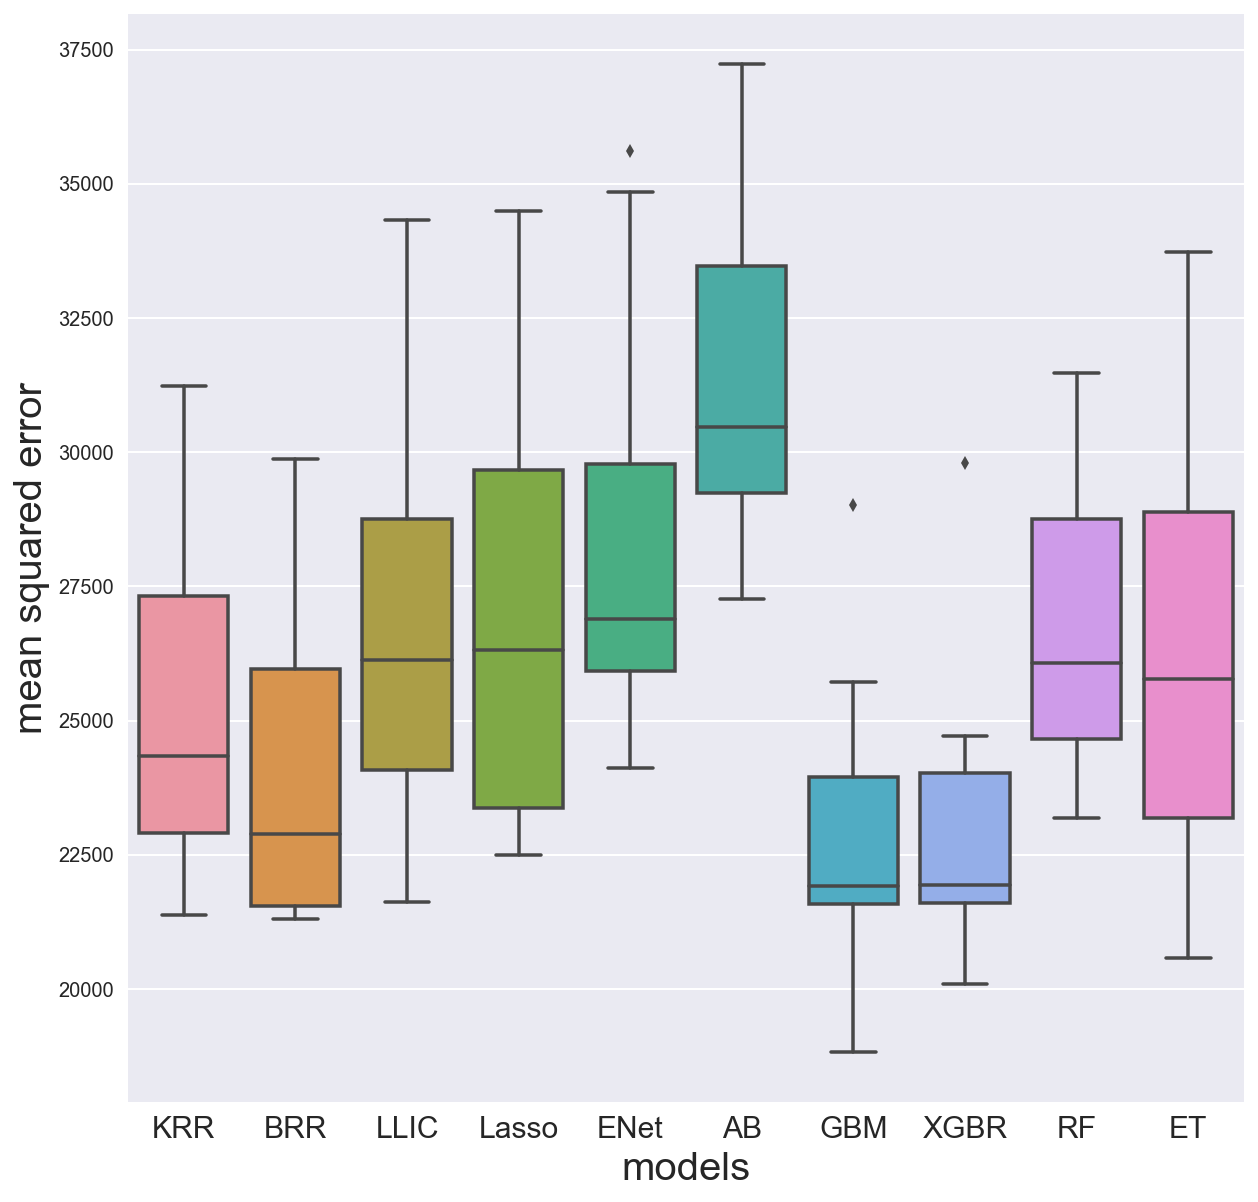

In [67]:
fig, ax = plt.subplots(figsize=(10,10))
fig = sns.boxplot(data=df_results)
fig = fig.set_xticklabels(labels = df_results.columns,fontdict={'fontsize':15})
ax.set_xlabel('models', size = 20)
ax.set_ylabel('mean squared error', size = 20)

XGBoostRegressor(), on average, seems to perform the best out of all of our models before tuning.

Eventhough we could stack our best models or compare our models after tuning their hyperparameters, XGBR seemed to perform so well relative to the other models that we'll move forward with only this model.

Before we tune this model, let's see if we can improve our performance by making a pipeline that includes a feature scalar.

In [68]:
%%capture

# pipelines
pipelines = []
pipelines.append(('XGBR',
                  Pipeline([('XGBR',XGBRegressor(random_state = 5))])))
pipelines.append(('ScaledXGBR', 
                  Pipeline([('Scaler', StandardScaler()),
                            ('GBM',XGBRegressor(random_state = 5))])))
pipelines.append(('RScaledXGBR', 
                  Pipeline([('RobustScaler', RobustScaler()),
                            ('GBM',XGBRegressor(random_state = 5))])))

# build dataframe
results = []
names = []
means = []
stddevs = []
n_folds = 10
for name, model in pipelines:
    kfold = KFold(n_splits=n_folds, random_state=7)
    cv_results = np.sqrt(-cross_val_score(model, train.values, y_train, cv=kfold, scoring="neg_mean_squared_error"))
    results.append(cv_results)
    means.append(cv_results.mean())
    stddevs.append(cv_results.std())
    names.append(name)
              
df_results = pd.DataFrame(np.array(results).T, columns = names)

In [69]:
# print mean and stddev root mean squared error from 10 fold 
for col in df_results:
    print("%s: %f (%f)" % (col, df_results[col].mean(), df_results[col].std()))

XGBR: 23056.107888 (2747.180104)
ScaledXGBR: 23056.800418 (2747.392141)
RScaledXGBR: 23048.314653 (2743.400086)


Since it seems to perform slighly better, after tuning hyperparameters we'll revisit the pipeline that includes robust scalar, which scales our features and is also robust to outliers.

### Hyperparameter tuning

We'll do a gridsearch of a parameter dictionary and find the best performing parameter combination

In [70]:
param_grid = {'n_estimators' : [600, 800, 1000, 1200], 'learning_rate' : [.03, .05, .1]}

In [71]:
grid = GridSearchCV(estimator = XGBRegressor(nthread = -1, random_state = 5),
                    param_grid = param_grid, 
                    scoring = 'neg_mean_squared_error', 
                    cv = 10, 
                    n_jobs = -1)

In [72]:
%%capture
grid_result = grid.fit(train.values, y_train)

In [73]:
print("Best: %f using %s" % (np.sqrt(-grid_result.best_score_), grid_result.best_params_))
means = np.sqrt(-grid_result.cv_results_['mean_test_score'])
params = grid_result.cv_results_['params']
for mean, param in zip(means, params):
    print("%f with: %r" % (mean, param))

Best: 22330.089992 using {'learning_rate': 0.05, 'n_estimators': 800}
22553.637914 with: {'learning_rate': 0.03, 'n_estimators': 600}
22414.066774 with: {'learning_rate': 0.03, 'n_estimators': 800}
22367.765331 with: {'learning_rate': 0.03, 'n_estimators': 1000}
22365.731391 with: {'learning_rate': 0.03, 'n_estimators': 1200}
22385.646378 with: {'learning_rate': 0.05, 'n_estimators': 600}
22330.089992 with: {'learning_rate': 0.05, 'n_estimators': 800}
22357.551123 with: {'learning_rate': 0.05, 'n_estimators': 1000}
22386.987729 with: {'learning_rate': 0.05, 'n_estimators': 1200}
22561.396143 with: {'learning_rate': 0.1, 'n_estimators': 600}
22599.573209 with: {'learning_rate': 0.1, 'n_estimators': 800}
22593.709691 with: {'learning_rate': 0.1, 'n_estimators': 1000}
22630.480573 with: {'learning_rate': 0.1, 'n_estimators': 1200}


We see that our model performs best with the following hyperparameters: {'learning_rate': 0.1, 'n_estimators': 600}.

Let's check to see if the tuned model still performs better with a scaler in the pipeline.

In [74]:
%%capture
# pipelines
pipelines = []
pipelines.append(('XGBR_tuned', Pipeline([('XGBR', XGBRegressor(n_estimators = 800, 
                                                           learning_rate = .05, 
                                                           random_state = 5))])))
pipelines.append(('RScaledXGBR_tuned', Pipeline([('RobustScaler', RobustScaler()), 
                                            ('GBM', XGBRegressor(n_estimators = 800, 
                                                                 learning_rate = .05, 
                                                                 random_state = 5))])))

# build dataframe
results = []
names = []
means = []
stddevs = []
n_folds = 10
for name, model in pipelines:
    kfold = KFold(n_splits=n_folds, random_state=7)
    cv_results = np.sqrt(-cross_val_score(model, train.values, y_train, cv=kfold, scoring="neg_mean_squared_error"))
    results.append(cv_results)
    means.append(cv_results.mean())
    stddevs.append(cv_results.std())
    names.append(name)
              
df_results = pd.DataFrame(np.array(results).T, columns = names)

In [75]:
# print mean and stddev root mean squared error from 10 fold 
for col in df_results:
    print("%s: %f (%f)" % (col, df_results[col].mean(), df_results[col].std()))

XGBR_tuned: 22150.698146 (2973.632052)
RScaledXGBR_tuned: 22147.040781 (2976.484380)


### Final model

Below is our final model, which at the time of it's completion was in the top ~10% of predictions on the kaggle leaderboard for this competition.

In [76]:
XGBRT = Pipeline([('RobustScaler', RobustScaler()), ('GBM', XGBRegressor(n_estimators = 800, 
                                                                         learning_rate = .05, 
                                                                         random_state = 5))])

In [77]:
%%capture
XGBRT_mod = XGBRT.fit(train.values,y_train)

In [78]:
finalMd = XGBRT_mod.predict(test.values)